## Contents<a id='3.1_Contents'></a>
* [3 Building Model](#3-Building-Mode)
  * [3.1 Introduction](#3.1-Introduction)
  * [3.2 Imports](#3.2-Imports)
  * [3.3 Load the data](#3.3-Load-the-data)
  * [3.4 Preparing the dataset for model training](#3.4-Preparing-the-dataset-for-model-training)
  * [3.5 Feature Selection](#3.5-Feature-Selection)
  * [3.5 Applying Machine Learning Algorithms](#3.5-Applying-Machine-Learning-Algorithms)
    * [3.5.1 Evaluating the impact of Log Transformations](#3.5.1-Evaluating-the-impact-of-Log-Transformations)
      + [3.5.1.1 Using Random Forest Classifier](#3.5.1.1-Using-Random-Forest-Classifier)
      + [3.5.1.2 Using XGBClassifier](#3.5.1.2-Using-XGBClassifier)
      + [3.5.1.3 Using all the available features and finding their importance](#3.5.1.3-Using-all-the-available-features-and-finding-their-importance)
  * [3.6 Dimensionality reduction (PCA)](#3.6-Dimensionality-reduction-(PCA))
  * [3.7 Machine Learning Algorithms](#3.7-Machine-Learning-Algorithms)
    * [3.7.1 Applying KNN](#3.7.1-Applying-KNN)
    * [3.7.2 Applying SVM](#3.7.2-Applying-SVM)
      + [3.7.2.1 Using GrivSearchCV for hyperparameter tuning of SVC](#3.7.2.1-Using-GrivSearchCV-for-hyperparameter-tuning-of-SVC)
    * [3.7.3 Improving XGBoostClassifer](#3.7.3-Improving-XGBoostClassifer)
      + [3.7.3.1 Hyperparameter tunning using RandomSearchCV](#3.7.3.1-Hyperparameter-tunning-using-RandomSearchCV)
    * [3.7.4 Using TF-IDF on 'url'](#3.7.4-Using-TF-IDF-on-'url')
  * [3.8 Comparing the Final Models](#3.8-Comparing-the-Final-Models)
  * [3.9 Scope for future improvements](#3.9-Scope-for-future-improvements)

# 3.1 Introduction

In our previous notebook (02_Feature_Engineering), we engineered multiple features based on URL structure, FQDN, TLD, and more. We also applied logarithmic transformation to some features.

We will begin by evaluating the impact of log transformation on our model’s performance by grouping features and comparing their predictive efficiency.

Next, we will explore two approaches for feature selection:

 * Domain Knowledge & Intuition: Selecting features based on our understanding of phishing characteristics.
 * Principal Component Analysis (PCA): Reducing dimensionality to optimize performance while minimizing computational costs.

After finalizing the feature set, we will experiment with various Machine Learning algorithms to identify the best-performing model. Our <b>Primary Evaluation Metric will be Recall for phishing URLs</b>, as minimizing False Negatives is crucial—misclassifying a phishing site as legitimate poses the highest risk in a real-world scenario.

# 3.2 Imports

In [1]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, make_scorer
from sklearn import tree, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# 3.3 Load the data

In [7]:
with open('../data/interim/new_data_url_all_features.pkl', 'rb') as f:
    df = pickle.load(f)

In [8]:
df.head()

,url,status,FQDN,tlds,len_url,len_url_log,len_FQDN,len_FQDN_log,len_tld,len_tld_log,...,sum_spe_prob_log,sum_spe_prob,similarity_index_legit,similarity_index_phi,similarity_index_legit_log,similarity_index_phi_log,english_words_url,english_word_count_url,english_words_FQDN,english_word_count_FQDN
0,0000111servicehelpdesk.godaddysites.com,0,0000111servicehelpdesk.godaddysites.com,com,39,3.688879,39,3.688879,3,1.386294,...,0.0,0.0,0,2,0.0,1.098612,[],0,[],0
1,000011accesswebform.godaddysites.com,0,000011accesswebform.godaddysites.com,com,36,3.610918,36,3.610918,3,1.386294,...,0.0,0.0,0,1,0.0,0.693147,[],0,[],0
2,00003.online,0,00003.online,online,12,2.564949,12,2.564949,6,1.945910,...,0.0,0.0,0,0,0.0,0.000000,[],0,[],0
3,0009servicedeskowa.godaddysites.com,0,0009servicedeskowa.godaddysites.com,com,35,3.583519,35,3.583519,3,1.386294,...,0.0,0.0,0,1,0.0,0.693147,[],0,[],0
4,000n38p.wcomhost.com,0,000n38p.wcomhost.com,com,20,3.044522,20,3.044522,3,1.386294,...,0.0,0.0,0,0,0.0,0.000000,"[n, p]",2,"[n, p]",2


# 3.4 Preparing the dataset for model training

In [9]:
text_features = df.select_dtypes(include=['object'])
df = df.drop(columns=text_features)

In [6]:
df.columns

Index(['status', 'len_url', 'len_url_log', 'len_FQDN', 'len_FQDN_log',
       'len_tld', 'len_tld_log', 'contains_ip', 'url_entropy', 'FQDN_entropy',
       'tld_entropy', 'url_tld_entropy', 'has_js', 'js_entropy', 'num_pat_3',
       'pat_3_entropy', 'pat_3_entropy_log', 'FQDN_len_capital',
       'FQDN_ratio_capital', 'url_len_capital', 'url_len_capital_log',
       'url_ratio_capital', 'url_ratio_capital_log', 'url_char_num_ratio',
       'url_char_num_ratio_log', 'url_spe_char_ratio',
       'url_spe_char_ratio_log', 'FQDN_char_num_ratio',
       'FQDN_char_num_ratio_log', 'FQDN_spe_char_ratio',
       'FQDN_spe_char_ratio_log', 'url_obfuscation_status',
       'FQDN_obfuscation_status', 'obfuscation_entropy_url',
       'obfuscation_entropy_FQDN', 'url_repeated_subs_weight',
       'num_url_reapeated_subs', 'url_num_chunk_weight', 'n_hypens',
       'n_hypens_log', 'n_uscores', 'n_uscores_log', 'n_semicolon',
       'n_semicolon_log', 'n_equal_sign', 'n_equal_sign_log', 'n_plus_si

We have quite a few feature here. We will divide them in groups based on our domain knowledge and intuition and try a Random Forest Classifier and a XGB model to test our groups.

In [5]:
# Feature set including log based transformation.
log_1 = ['status', 'len_url_log', 'len_FQDN_log',
       'len_tld_log', 'contains_ip', 'url_entropy', 'FQDN_entropy',
       'tld_entropy', 'url_tld_entropy', 'has_js', 'js_entropy', 'num_pat_3',
       'pat_3_entropy_log','FQDN_ratio_capital', 'url_len_capital_log',
       'url_ratio_capital_log', 'url_char_num_ratio_log',  
       'url_spe_char_ratio_log', 'FQDN_char_num_ratio','FQDN_spe_char_ratio_log', 'url_obfuscation_status',
       'FQDN_obfuscation_status', 'obfuscation_entropy_url',
       'obfuscation_entropy_FQDN', 'url_repeated_subs_weight',  
       'num_url_reapeated_subs', 'url_num_chunk_weight', 
       'n_hypens_log', 'n_uscores_log', 'n_semicolon_log',  'n_equal_sign_log', 
       'n_plus_sign_log', 'num_segments_FQDN', 
       'FQDN_seg_dot_sep_entropy_log','tld_fuzzy_score_lev_log', 'tld_fuzzy_score_da_nor','tld_similarity_jaro_winkler', 
       'dot_probability_log', 'sum_spe_prob_log',
       'similarity_index_legit_log', 'similarity_index_phi_log','english_word_count_url', 'english_word_count_FQDN']

In [23]:
len(log_1)

43

In [9]:
df_log_1 = df[log_1]

In [13]:
# Features set without the log based transformations
basic_features = ['status', 'len_url','len_FQDN',
       'len_tld','contains_ip', 'url_entropy', 'FQDN_entropy',
       'tld_entropy', 'url_tld_entropy', 'has_js', 'js_entropy', 'num_pat_3',
       'pat_3_entropy','FQDN_ratio_capital', 'url_len_capital',
       'url_ratio_capital', 'url_char_num_ratio','url_spe_char_ratio','FQDN_char_num_ratio',
       'FQDN_spe_char_ratio','url_obfuscation_status','FQDN_obfuscation_status', 'obfuscation_entropy_url',
       'obfuscation_entropy_FQDN', 'url_repeated_subs_weight',          
       'num_url_reapeated_subs', 'url_num_chunk_weight', 'n_hypens','n_uscores','n_semicolon','n_equal_sign', 'n_plus_sign',
       'num_segments_FQDN', 'FQDN_seg_dot_sep_entropy',         
       'tld_fuzzy_score_lev','tld_fuzzy_score_da_nor','tld_similarity_jaro_winkler','dot_probability',
       'sum_spe_prob', 'similarity_index_legit', 'similarity_index_phi',
       'english_word_count_url', 'english_word_count_FQDN']

In [29]:
len(basic_features)

43

In [15]:
df_2 = df[basic_features]

# 3.5 Feature Selection

### 3.5.1 Evaluating the impact of Log Transformations

<b>We will use two simple models (without hyperparameter tuning) RandomForestClassifier and XGBoost Classifier to evaluate the impact of log transformation on the prediction scores.

In [34]:
X = df_log_1.drop(columns=['status']) 
y = df_log_1['status']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### 3.5.1.1 Using Random Forest Classifier

##### Using the log transformed features

In [36]:
rf_log = RandomForestClassifier(criterion='entropy', random_state=42, max_depth=10)

rf_log.fit(X_train,y_train)

y_pred = rf_log.predict(X_test)

y_pred = pd.Series(y_pred)

rf_log

RandomForestClassifier(criterion='entropy', max_depth=10, random_state=42)

In [37]:
# Model evaluation metrics 
print("Model Entropy - random forest log features max depth 10")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "legitimate_url"' , metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Precision score for "phishing_url"' , metrics.precision_score(y_test,y_pred, pos_label = 0))
print('Recall score for "legitimate_url"' , metrics.recall_score(y_test,y_pred, pos_label = 1))
print('Recall score for "phishing_url"' , metrics.recall_score(y_test,y_pred, pos_label = 0))

Model Entropy - random forest log features max depth 10
Accuracy: 0.8463376732725371
Balanced accuracy: 0.8438769936188373
Precision score for "legitimate_url" 0.832746788667957
Precision score for "phishing_url" 0.8638430483745307
Recall score for "legitimate_url" 0.8873576149627338
Recall score for "phishing_url" 0.8003963722749406


                         Feature  Importance
36           dot_probability_log    0.090931
39      similarity_index_phi_log    0.074664
7                url_tld_entropy    0.069150
0                    len_url_log    0.060244
1                   len_FQDN_log    0.059367
35   tld_similarity_jaro_winkler    0.055371
17           FQDN_char_num_ratio    0.052038
5                   FQDN_entropy    0.050345
32  FQDN_seg_dot_sep_entropy_log    0.042850
34        tld_fuzzy_score_da_nor    0.038756
33       tld_fuzzy_score_lev_log    0.037849
4                    url_entropy    0.037448
16        url_spe_char_ratio_log    0.037105
2                    len_tld_log    0.033512
6                    tld_entropy    0.032601
26                  n_hypens_log    0.032044
21       obfuscation_entropy_url    0.020671
25          url_num_chunk_weight    0.020320
31             num_segments_FQDN    0.017511
18       FQDN_spe_char_ratio_log    0.017320


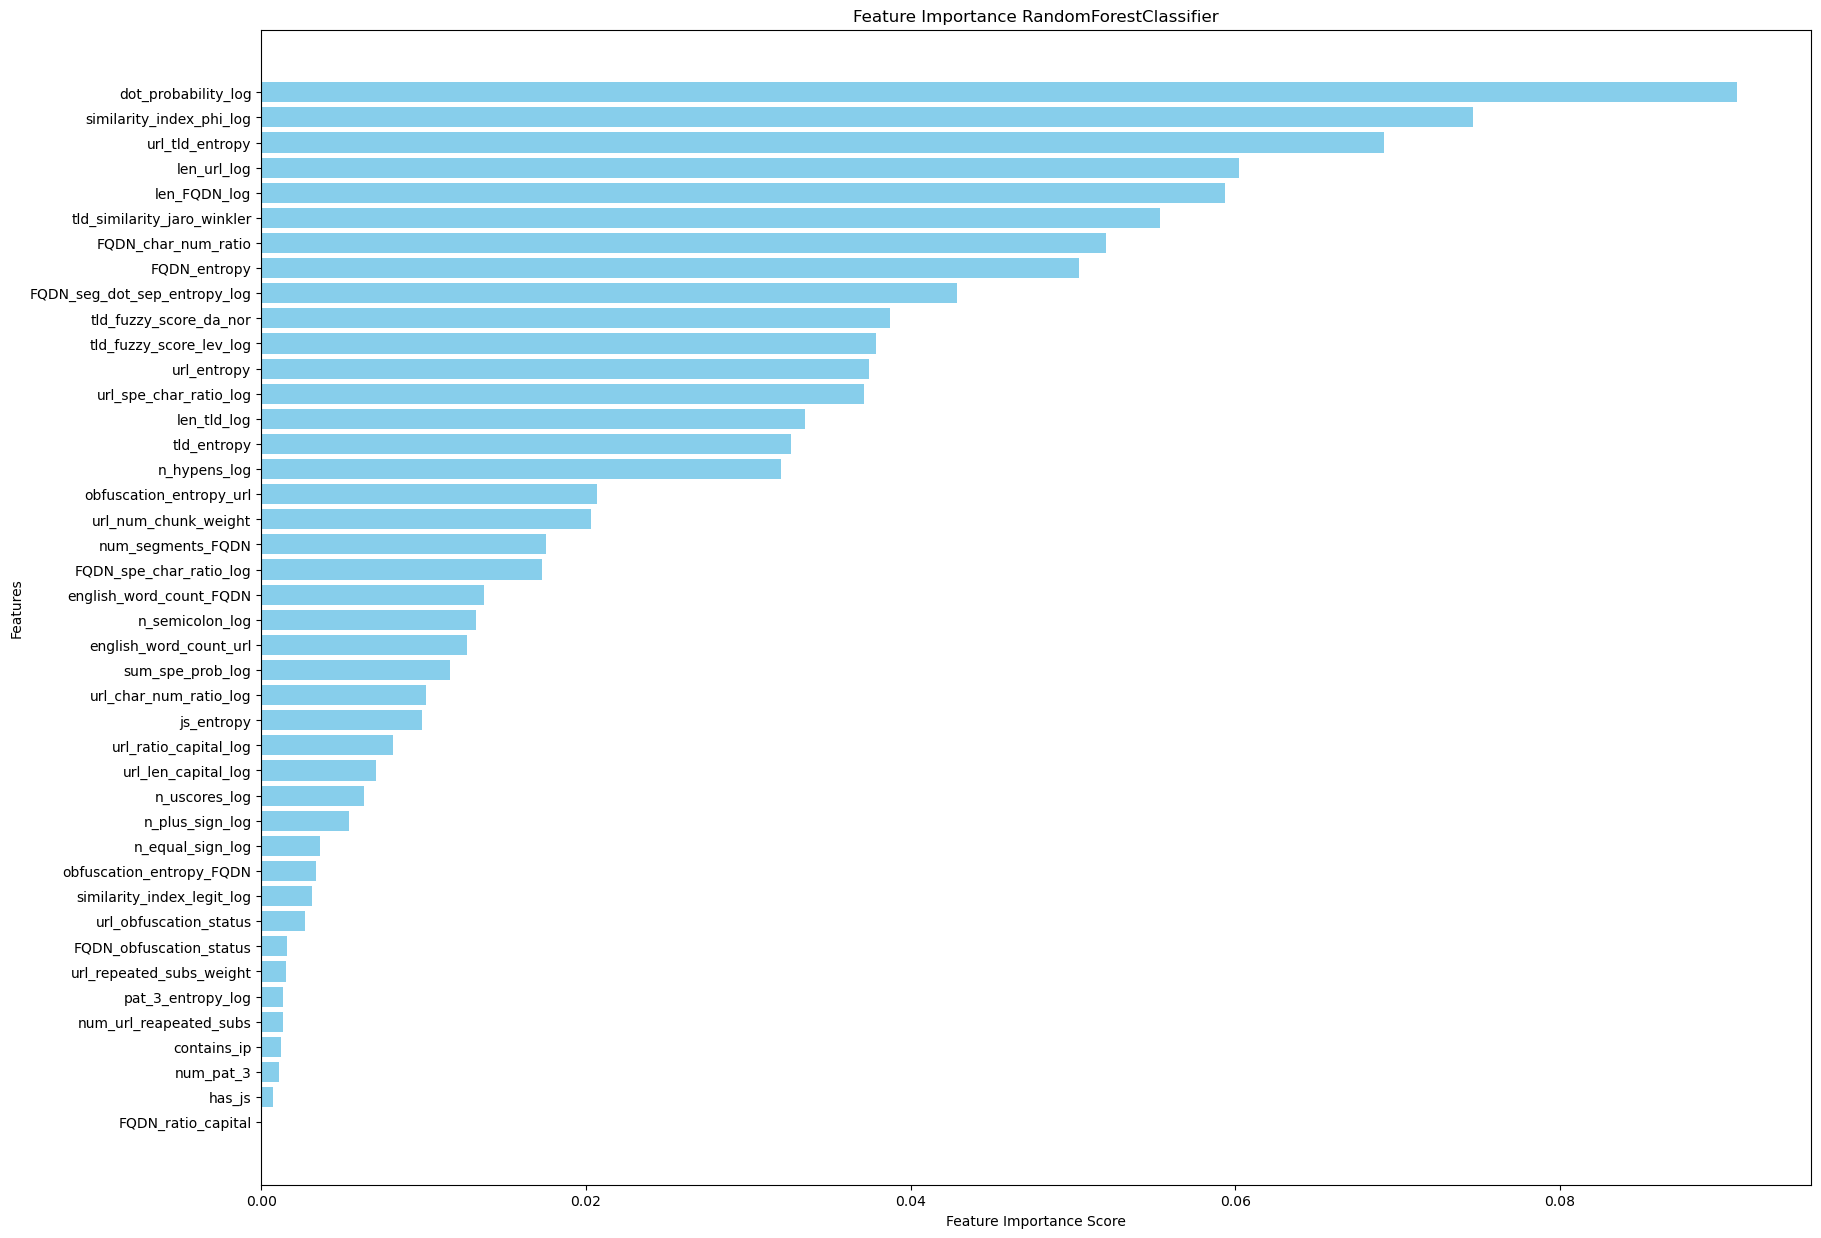

In [38]:
# Extracting feature importances
feature_importance = rf_log.feature_importances_

# Creating a DataFrame
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

print(importance_df.head(20))

# Plotting feature importance
plt.figure(figsize=(20, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance RandomForestClassifier")
plt.show()

##### Using the basic features

In [39]:
X = df_2.drop(columns=['status']) 
y = df_2['status'] 

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [41]:
rf_2 = RandomForestClassifier(criterion='entropy', random_state=42, max_depth=10)

rf_2.fit(X_train,y_train)

y_pred = rf_2.predict(X_test)

y_pred = pd.Series(y_pred)

rf_2

RandomForestClassifier(criterion='entropy', max_depth=10, random_state=42)

In [42]:
# Model evaluation metrics 
print("Model Entropy - Random Forest basic features max depth 10")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "legitimate_url"' , metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Precision score for "phishing_url"' , metrics.precision_score(y_test,y_pred, pos_label = 0))
print('Recall score for "legitimate_url"' , metrics.recall_score(y_test,y_pred, pos_label = 1))
print('Recall score for "phishing_url"' , metrics.recall_score(y_test,y_pred, pos_label = 0))

Model Entropy - Random Forest basic features max depth 10
Accuracy: 0.846306717928716
Balanced accuracy: 0.8438610530643166
Precision score for "legitimate_url" 0.8328767123287671
Precision score for "phishing_url" 0.863586171748917
Recall score for "legitimate_url" 0.8870763605681339
Recall score for "phishing_url" 0.8006457455604993


```
RandomForestClassifier (Result for Log based vs. Basic features)

                                          log features    Basic features 
Accuracy                            :     0.8463          0.8463
Precision score for "legitimate_url":     0.8327          0.8328
Precision score for "phishing_url"  :     0.8638          0.8635
Recall score for "legitimate_url"   :     0.8873          0.8870
Recall score for "phishing_url"     :     0.8003          0.8006
```

<b>The difference is only merginal when using log based transformations for RandomForestClassifier.<b/>

                        Feature  Importance
36              dot_probability    0.090739
39         similarity_index_phi    0.072914
7               url_tld_entropy    0.069004
0                       len_url    0.061333
1                      len_FQDN    0.059149
35  tld_similarity_jaro_winkler    0.055907
17          FQDN_char_num_ratio    0.052443
5                  FQDN_entropy    0.050648
32     FQDN_seg_dot_sep_entropy    0.045512
33          tld_fuzzy_score_lev    0.038836
4                   url_entropy    0.038462
34       tld_fuzzy_score_da_nor    0.038089
16           url_spe_char_ratio    0.036448
6                   tld_entropy    0.032775
2                       len_tld    0.032652
26                     n_hypens    0.031165
21      obfuscation_entropy_url    0.020612
25         url_num_chunk_weight    0.020294
18          FQDN_spe_char_ratio    0.017698
31            num_segments_FQDN    0.017008


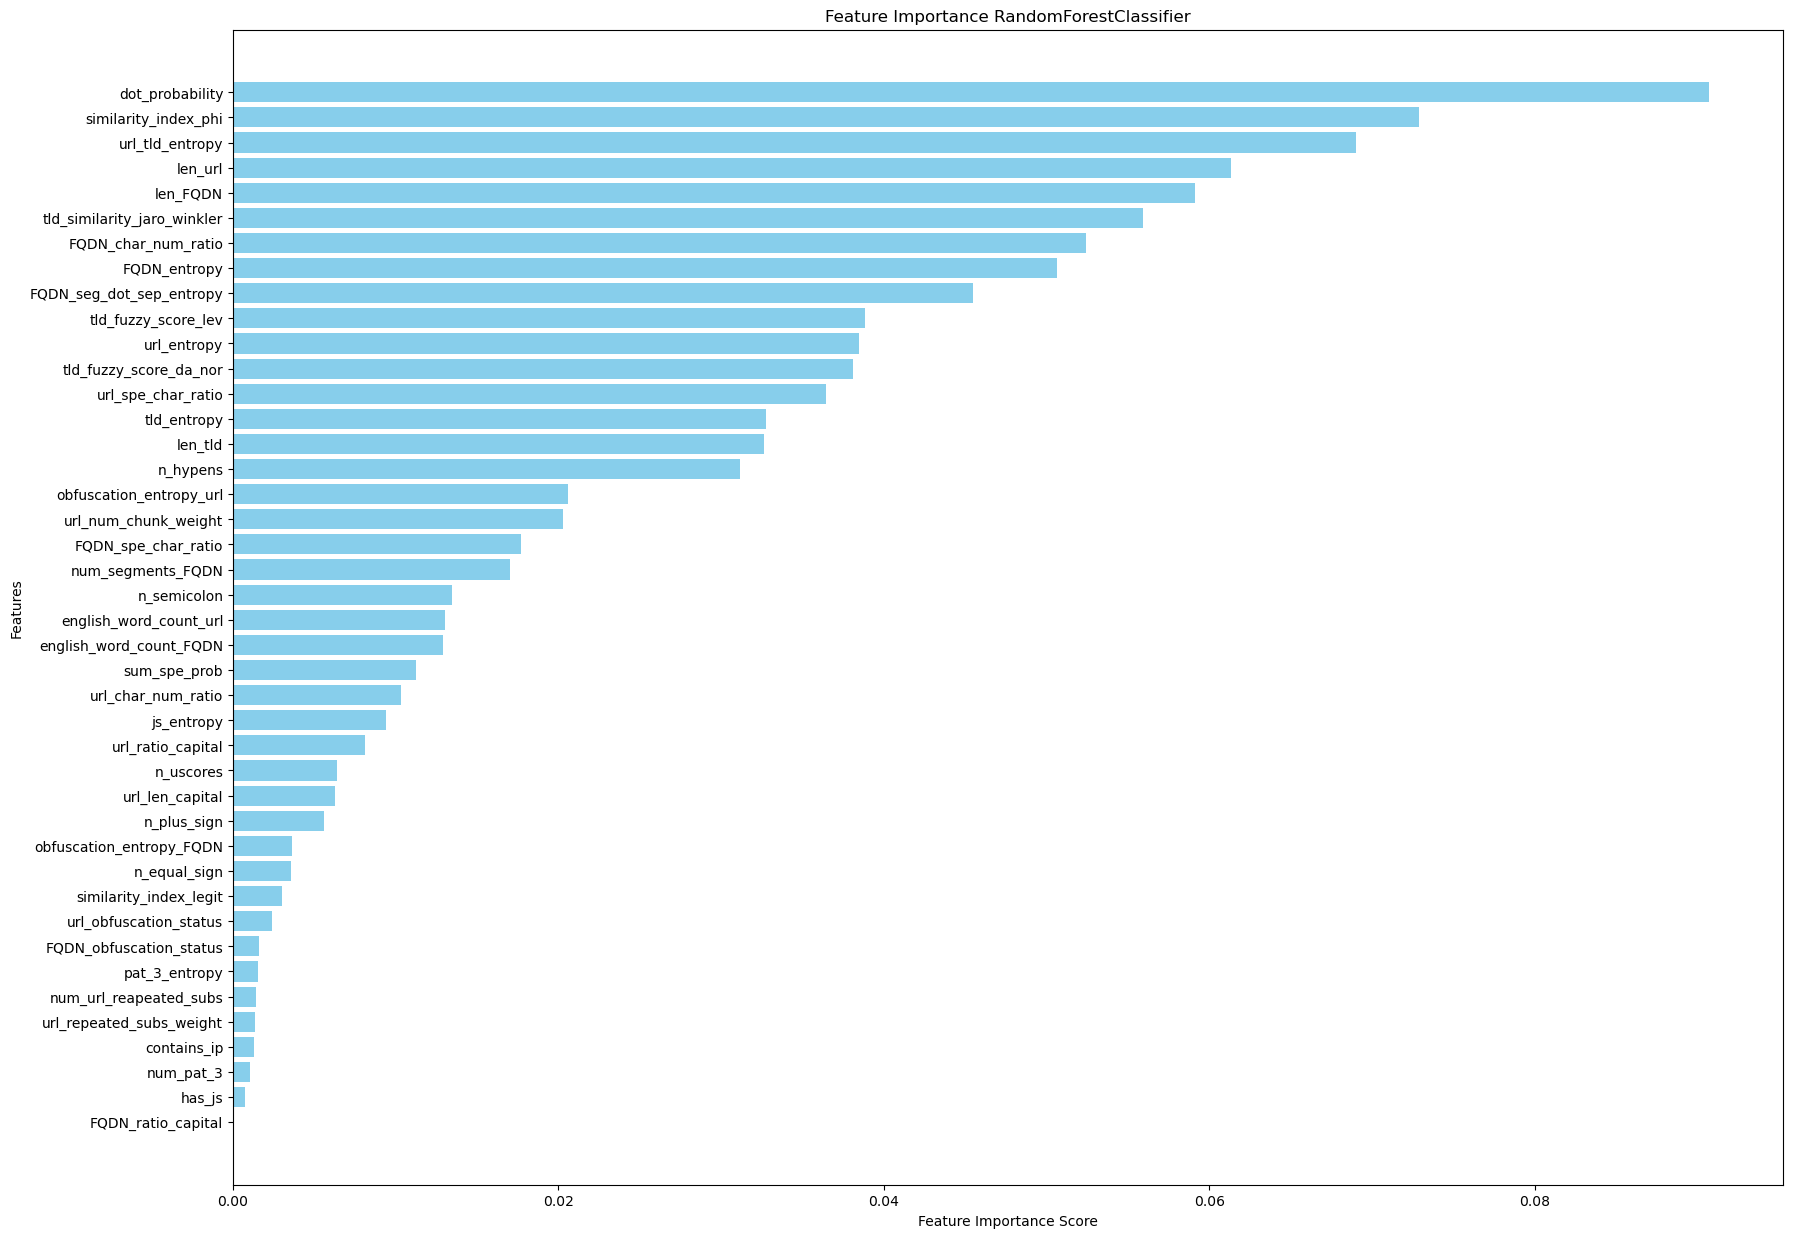

In [43]:
# Extracting feature importances
feature_importance = rf_2.feature_importances_

# Creating a DataFrame
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

print(importance_df.head(20))

# Plotting feature importance
plt.figure(figsize=(20, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance RandomForestClassifier")
plt.show()

#### 3.5.1.2 Using XGBClassifier

##### Using log transformed features

In [44]:
X = df_log_1.drop(columns=['status']) 
y = df_log_1['status']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [45]:
xgb = XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.1, eval_metric="logloss")
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

In [46]:
# Calculate recall and F1-score for phishing URLs (0)
recall_phishing = recall_score(y_test, y_pred, pos_label=0)
f1_phishing = f1_score(y_test, y_pred, pos_label=0)

# Calculate recall and F1-score for legitimate URLs (1)
recall_legitimate = recall_score(y_test, y_pred, pos_label=1)
f1_legitimate = f1_score(y_test, y_pred, pos_label=1)

print(f"Phishing URLs (0) - Recall: {recall_phishing:.4f}, F1-score: {f1_phishing:.4f}")
print(f"Legitimate URLs (1) - Recall: {recall_legitimate:.4f}, F1-score: {f1_legitimate:.4f}")

Phishing URLs (0) - Recall: 0.8945, F1-score: 0.9006
Legitimate URLs (1) - Recall: 0.9179, F1-score: 0.9124


                        Feature  Importance
39     similarity_index_phi_log    0.272900
6                   tld_entropy    0.172918
28              n_semicolon_log    0.074857
2                   len_tld_log    0.038182
36          dot_probability_log    0.036332
30              n_plus_sign_log    0.036160
38   similarity_index_legit_log    0.032294
17          FQDN_char_num_ratio    0.024401
25         url_num_chunk_weight    0.021786
35  tld_similarity_jaro_winkler    0.020772
3                   contains_ip    0.020141
26                 n_hypens_log    0.017692
31            num_segments_FQDN    0.016954
1                  len_FQDN_log    0.016486
34       tld_fuzzy_score_da_nor    0.012833
16       url_spe_char_ratio_log    0.012150
0                   len_url_log    0.011520
29             n_equal_sign_log    0.011191
8                        has_js    0.011019
27                n_uscores_log    0.010857


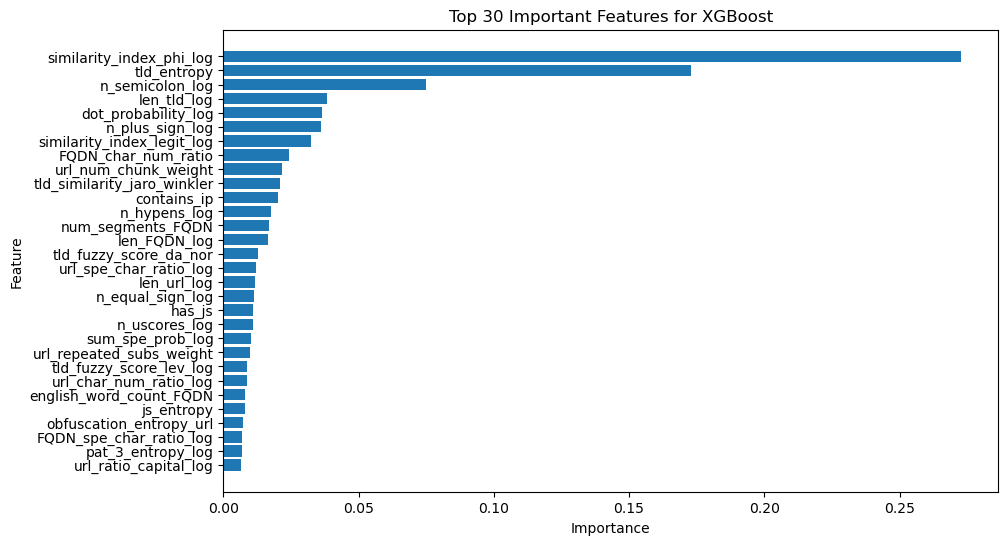

In [47]:
importances = xgb.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 20 most important features
print(feature_importance_df.head(20))

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:30], feature_importance_df['Importance'][:30])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Important Features for XGBoost')
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.show()

Some note on the feature importances

##### Using basic features

In [53]:
X = df_2.drop(columns=['status']) 
y = df_2['status']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [54]:
xgb = XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.1, eval_metric="logloss")
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

In [55]:
# Calculate recall and F1-score for phishing URLs (0)
recall_phishing = recall_score(y_test, y_pred, pos_label=0)
f1_phishing = f1_score(y_test, y_pred, pos_label=0)

# Calculate recall and F1-score for legitimate URLs (1)
recall_legitimate = recall_score(y_test, y_pred, pos_label=1)
f1_legitimate = f1_score(y_test, y_pred, pos_label=1)

print(f"Phishing URLs (0) - Recall: {recall_phishing:.4f}, F1-score: {f1_phishing:.4f}")
print(f"Legitimate URLs (1) - Recall: {recall_legitimate:.4f}, F1-score: {f1_legitimate:.4f}")

Phishing URLs (0) - Recall: 0.8944, F1-score: 0.9009
Legitimate URLs (1) - Recall: 0.9186, F1-score: 0.9127


```
XGB Classifier (Log vs. Basic features)

Basic features  
Phishing URLs (0) - Recall: 0.8944, F1-score: 0.9009
Legitimate URLs (1) - Recall: 0.9186, F1-score: 0.9127

Log transformed features
Phishing URLs (0) - Recall: 0.8945, F1-score: 0.9006
Legitimate URLs (1) - Recall: 0.9179, F1-score: 0.9124
```

<b>For XGB Classifer the differences are marginal also. In this Case Basic feature gives a slight improved resutls

                        Feature  Importance
39         similarity_index_phi    0.264499
6                   tld_entropy    0.175203
28                  n_semicolon    0.078905
2                       len_tld    0.040905
30                  n_plus_sign    0.037492
36              dot_probability    0.036138
38       similarity_index_legit    0.030633
3                   contains_ip    0.023804
17          FQDN_char_num_ratio    0.023061
25         url_num_chunk_weight    0.022168
35  tld_similarity_jaro_winkler    0.020690
26                     n_hypens    0.016972
1                      len_FQDN    0.016069
31            num_segments_FQDN    0.015686
34       tld_fuzzy_score_da_nor    0.012326
16           url_spe_char_ratio    0.012315
29                 n_equal_sign    0.011283
0                       len_url    0.011260
27                    n_uscores    0.010879
37                 sum_spe_prob    0.010251


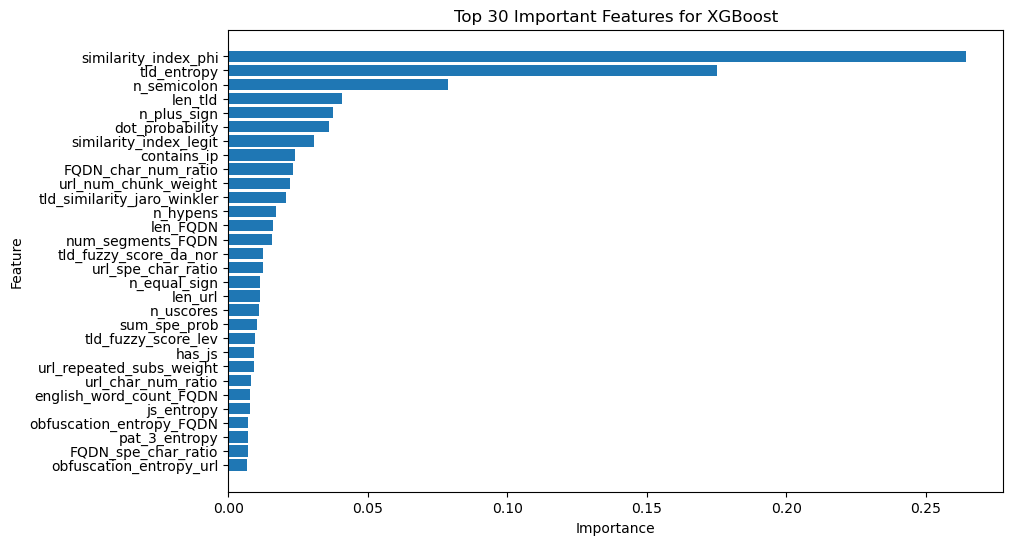

In [56]:
importances = xgb.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(20))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:30], feature_importance_df['Importance'][:30])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Important Features for XGBoost')
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.show()

#### 3.5.1.3 Using all the available features and finding their importance

In [57]:
X = df.drop(columns=['status']) 
y = df['status']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##### Random Forest Classifier

In [58]:
rf_all = RandomForestClassifier(criterion='entropy', random_state=42, max_depth=10)

rf_all.fit(X_train,y_train)

y_pred = rf_all.predict(X_test)

y_pred = pd.Series(y_pred)

rf_all

RandomForestClassifier(criterion='entropy', max_depth=10, random_state=42)

In [59]:
# Model evaluation metrics 
print("Model Entropy - random forest all features max depth 10")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "legitimate_url"' , metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Precision score for "phishing_url"' , metrics.precision_score(y_test,y_pred, pos_label = 0))
print('Recall score for "legitimate_url"' , metrics.recall_score(y_test,y_pred, pos_label = 1))
print('Recall score for "phishing_url"' , metrics.recall_score(y_test,y_pred, pos_label = 0))

Model Entropy - random forest all features max depth 10
Accuracy: 0.8471734675557041
Balanced accuracy: 0.8442898138826702
Precision score for "legitimate_url" 0.8291060245932775
Precision score for "phishing_url" 0.8711662631154157
Recall score for "legitimate_url" 0.8952444569446397
Recall score for "phishing_url" 0.7933351708207006


                         Feature  Importance
65           dot_probability_log    0.059091
55               dot_probability    0.047690
79      similarity_index_phi_log    0.044952
0                        len_url    0.044579
10               url_tld_entropy    0.043570
77          similarity_index_phi    0.041561
2                       len_FQDN    0.039357
27       FQDN_char_num_ratio_log    0.037849
1                    len_url_log    0.036800
9                    tld_entropy    0.034608
3                   len_FQDN_log    0.031236
51       tld_fuzzy_score_lev_log    0.029104
53   tld_similarity_jaro_winkler    0.028475
26           FQDN_char_num_ratio    0.028119
50           tld_fuzzy_score_lev    0.025372
8                   FQDN_entropy    0.025070
5                    len_tld_log    0.024693
49  FQDN_seg_dot_sep_entropy_log    0.024429
48      FQDN_seg_dot_sep_entropy    0.023356
7                    url_entropy    0.022902


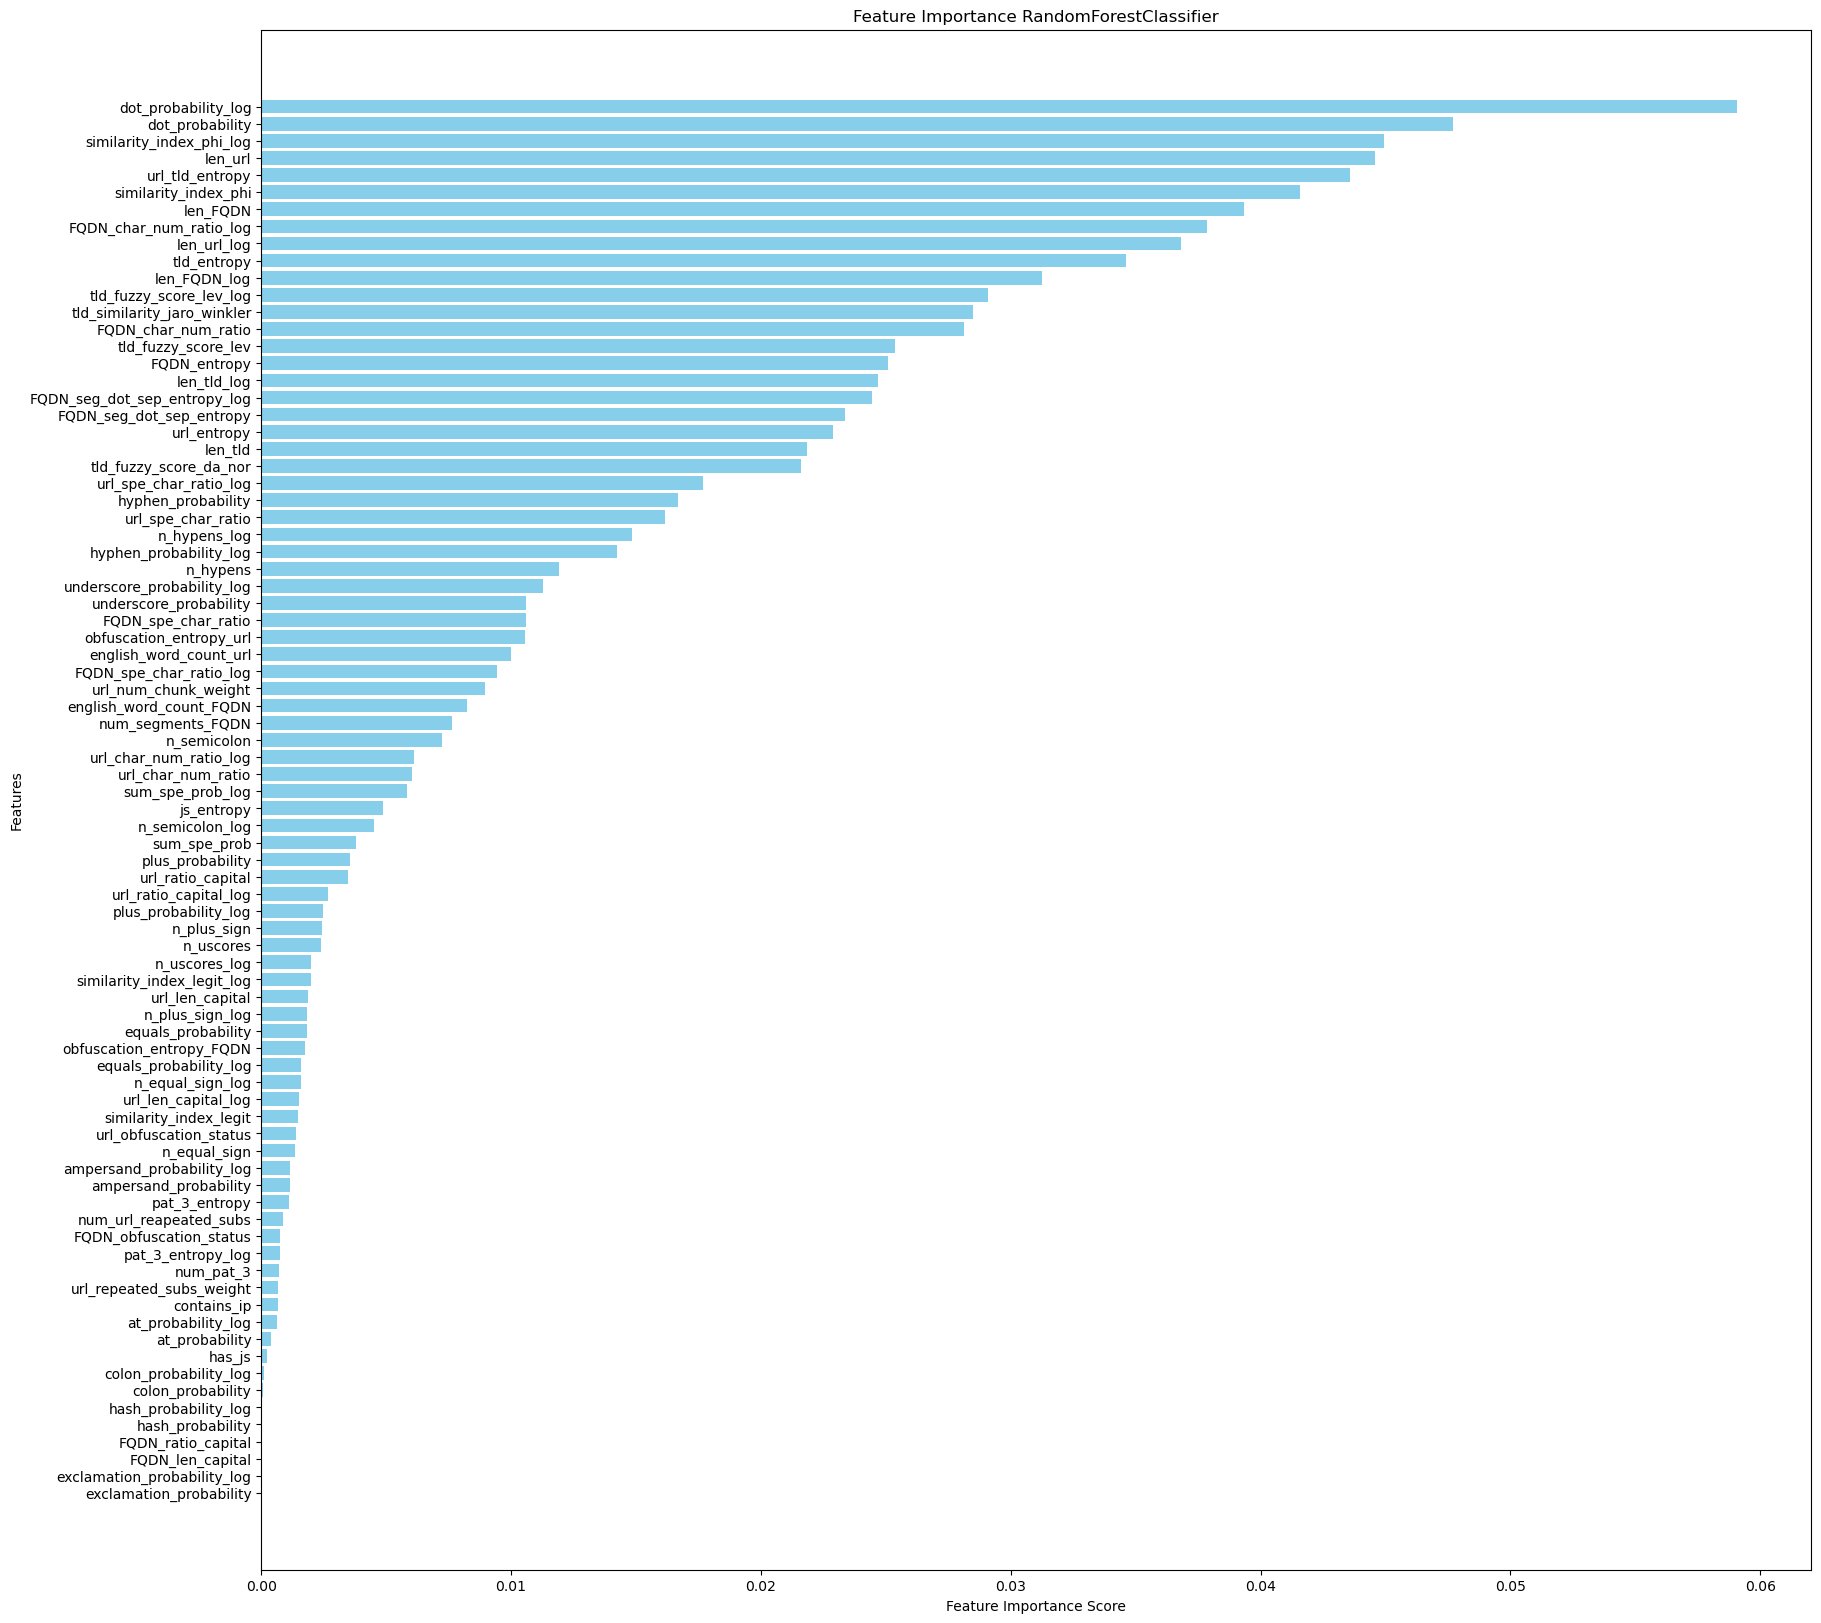

In [60]:
# Extracting feature importances
feature_importance = rf_all.feature_importances_

# Creating a DataFrame
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

print(importance_df.head(20))

# Plotting feature importance
plt.figure(figsize=(20, 20))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance RandomForestClassifier")
plt.show()

##### Using XGB Classifier

In [65]:
xgb = XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.1, eval_metric="logloss")
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

In [66]:
# Calculate recall and F1-score for phishing URLs (0)
recall_phishing = recall_score(y_test, y_pred, pos_label=0)
f1_phishing = f1_score(y_test, y_pred, pos_label=0)

# Calculate recall and F1-score for legitimate URLs (1)
recall_legitimate = recall_score(y_test, y_pred, pos_label=1)
f1_legitimate = f1_score(y_test, y_pred, pos_label=1)

print(f"Phishing URLs (0) - Recall: {recall_phishing:.4f}, F1-score: {f1_phishing:.4f}")
print(f"Legitimate URLs (1) - Recall: {recall_legitimate:.4f}, F1-score: {f1_legitimate:.4f}")

Phishing URLs (0) - Recall: 0.8946, F1-score: 0.9008
Legitimate URLs (1) - Recall: 0.9181, F1-score: 0.9125


In [71]:
importances = xgb.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 20 most important features
print(feature_importance_df.head(20))

                        Feature  Importance
77         similarity_index_phi    0.234936
9                   tld_entropy    0.143995
41                  n_semicolon    0.066919
63             plus_probability    0.042662
55              dot_probability    0.034198
56               at_probability    0.034117
4                       len_tld    0.032746
76       similarity_index_legit    0.028454
45                  n_plus_sign    0.025512
6                   contains_ip    0.021968
75                 sum_spe_prob    0.020675
36         url_num_chunk_weight    0.020173
26          FQDN_char_num_ratio    0.020118
37                     n_hypens    0.018696
53  tld_similarity_jaro_winkler    0.017965
2                      len_FQDN    0.014340
47            num_segments_FQDN    0.013947
59       underscore_probability    0.012289
24           url_spe_char_ratio    0.010836
43                 n_equal_sign    0.010771


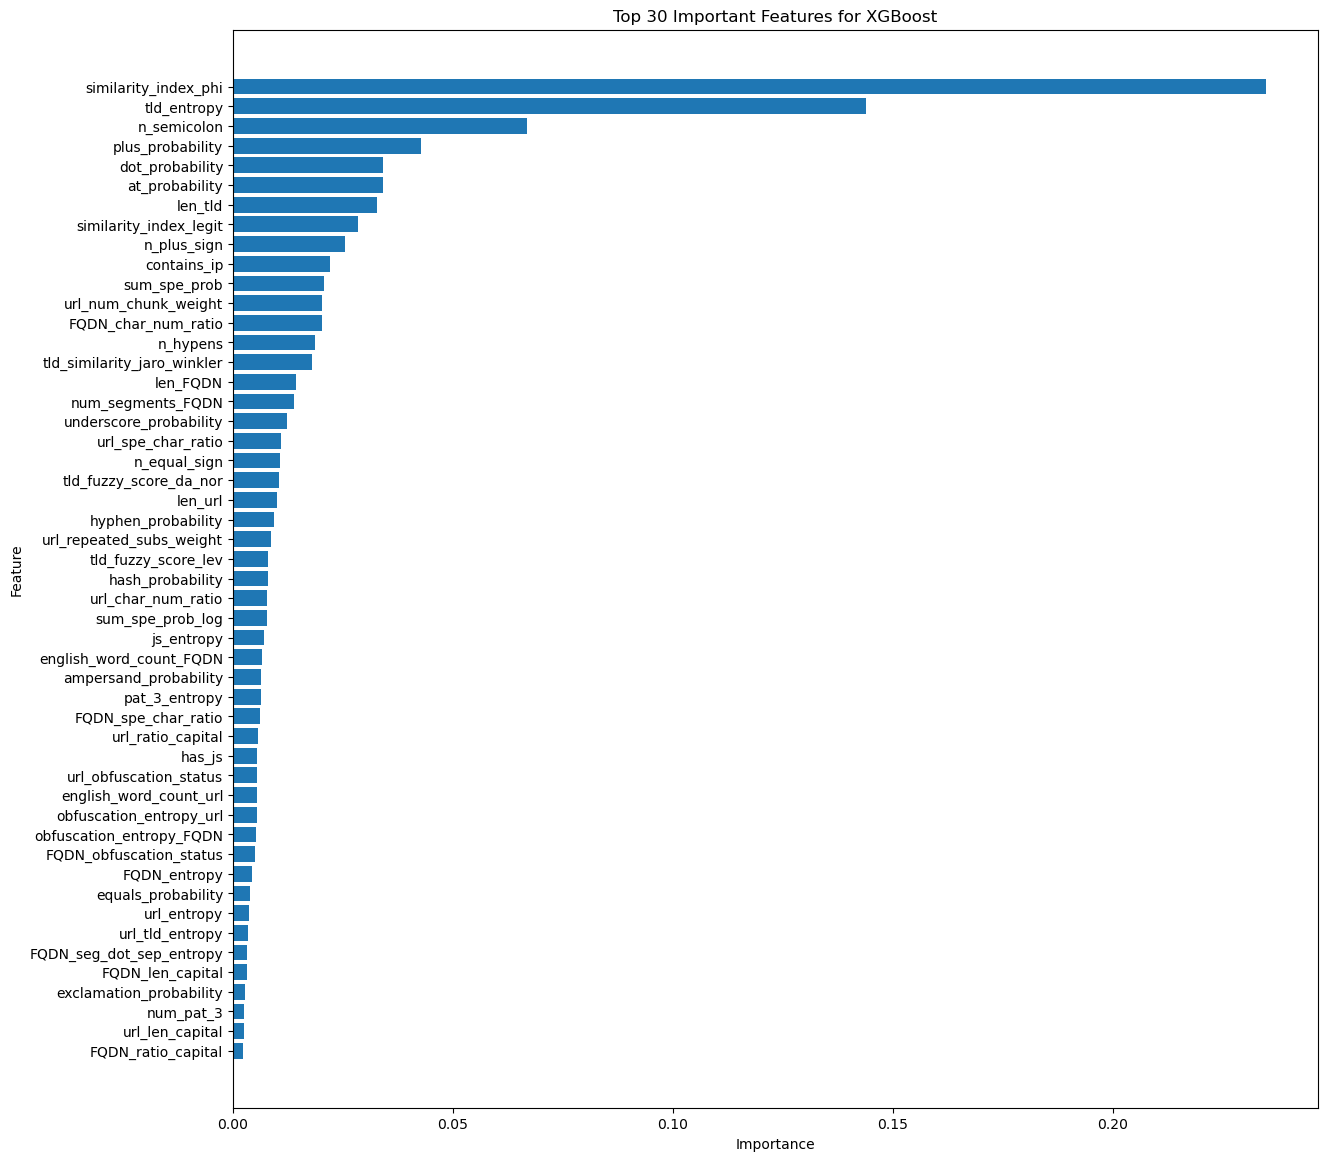

In [72]:
# Plot the feature importances
plt.figure(figsize=(14, 14))
plt.barh(feature_importance_df['Feature'][:50], feature_importance_df['Importance'][:50])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Important Features for XGBoost')
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.show()

##### Comparing the importance of different features from both the models

In [77]:
# Extracting feature importances for RandomForestClassifer
rf_feature_importance = rf_all.feature_importances_

# Creating DataFrame for RandomForestClassifier
rf_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'rf_feature': rf_feature_importance
}).sort_values(by='rf_feature', ascending=False)

# Extracting feature importances for XGBoost
xgb_feature_importance = xgb.feature_importances_

# Creating DataFrame for XGBoost
xgb_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'xgb_feature': xgb_feature_importance
}).sort_values(by='xgb_feature', ascending=False)

# Merging both DataFrames on 'Feature'
merged_df = pd.merge(rf_feature_importance_df[['Feature', 'rf_feature']], 
                     xgb_feature_importance_df[['Feature', 'xgb_feature']], 
                     on='Feature', 
                     how='inner')

# Sorting the merged DataFrame by RandomForestClassifier (rf_feature) importance
merged_df = merged_df.sort_values(by='rf_feature', ascending=False)

print(merged_df.head(20))

                         Feature  rf_feature  xgb_feature
0            dot_probability_log    0.059091     0.000000
1                dot_probability    0.047690     0.034198
2       similarity_index_phi_log    0.044952     0.000000
3                        len_url    0.044579     0.010031
4                url_tld_entropy    0.043570     0.003344
5           similarity_index_phi    0.041561     0.234936
6                       len_FQDN    0.039357     0.014340
7        FQDN_char_num_ratio_log    0.037849     0.000000
8                    len_url_log    0.036800     0.000000
9                    tld_entropy    0.034608     0.143995
10                  len_FQDN_log    0.031236     0.000000
11       tld_fuzzy_score_lev_log    0.029104     0.000000
12   tld_similarity_jaro_winkler    0.028475     0.017965
13           FQDN_char_num_ratio    0.028119     0.020118
14           tld_fuzzy_score_lev    0.025372     0.007931
15                  FQDN_entropy    0.025070     0.004226
16            

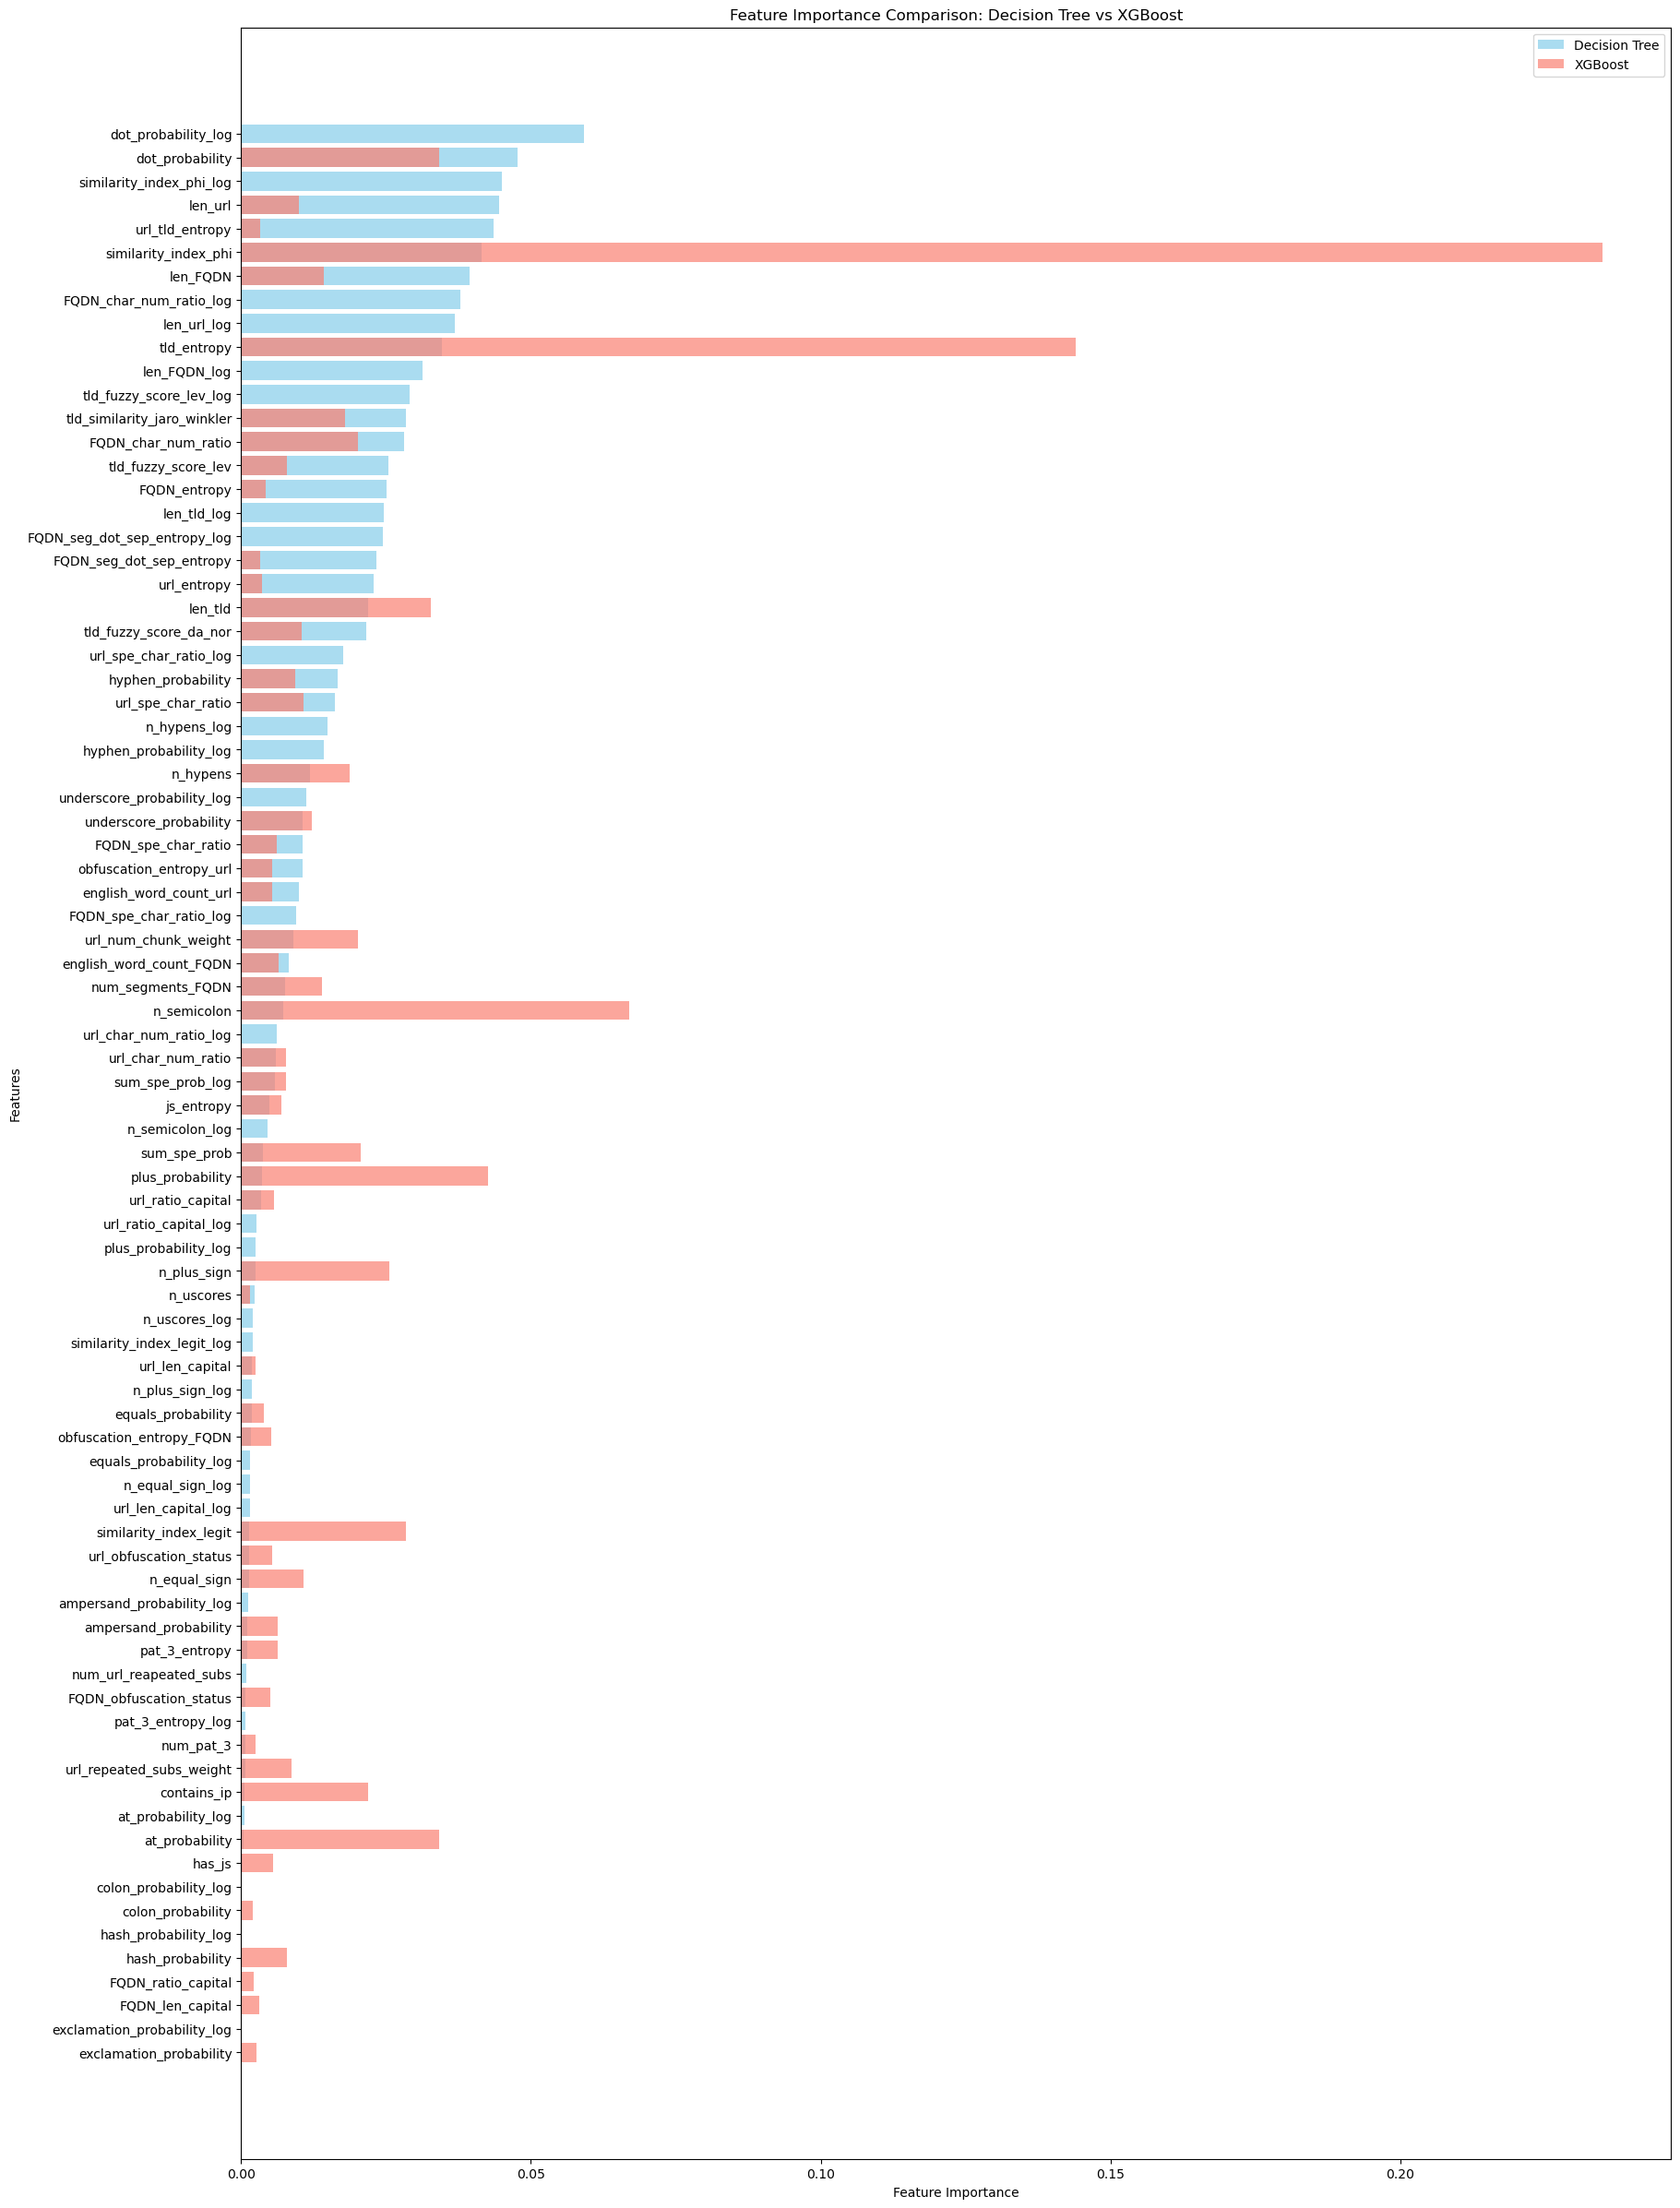

In [78]:
# Plotting feature importance comparison
plt.figure(figsize=(20, 30))

# Plot for RF
plt.barh(merged_df['Feature'], merged_df['rf_feature'], color="skyblue", label="Decision Tree", alpha=0.7)

# Plot for XGBoost
plt.barh(merged_df['Feature'], merged_df['xgb_feature'], color="salmon", label="XGBoost", alpha=0.7)

plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Comparison: Decision Tree vs XGBoost')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

<b>The importance of different features are quite different for the two models

<b>XGB Heavily Prioritizes a Few Features</b>

The feature similarity_index_phi has 0.2349 importance in XGB but only 0.0416 in RF.
tld_entropy has 0.1439 in XGB but only 0.0346 in RF.
This suggests that XGB assigns higher weight to a few dominant features while ignoring others (many log-transformed features have 0.0000 importance in XGB).

<b>RF Distributes Importance More Evenly</b>

RF considers more features significant, with no single feature dominating.
Even log-transformed features like dot_probability_log (0.0591), similarity_index_phi_log (0.0449), and FQDN_char_num_ratio_log (0.0378) contribute.
This indicates that RF benefits from a diverse set of features, unlike XGB, which is more selective.

<b>Log-Transformed Features are Less Important in XGB</b>

Many log-transformed features have 0.0000 importance in XGB but nonzero values in RF (e.g., dot_probability_log, similarity_index_phi_log, len_url_log).
This suggests that XGB doesn't gain much from log transformations, possibly because it already handles skewed distributions through gradient boosting and tree depth tuning.

<b>XGB Prefers Features with Strong Discriminative Power</b>

XGB relies on features that directly separate phishing from legitimate URLs, such as similarity_index_phi and tld_entropy.
It seems to ignore log-transformed variants, meaning that for XGB, raw feature values might already be well-separated.

<b>Random Forest Benefits from transformed Features</b>

Since RF is an ensemble of many independent trees, it gains from transformed features that reduce skewness (e.g., dot_probability_log and FQDN_char_num_ratio_log).
This suggests that feature log transformations helps RF more than XGB.

# 3.6 Dimensionality reduction (PCA)

In [8]:
with open('../data/interim/new_data_url_all_features.pkl', 'rb') as f:
    df = pickle.load(f)
text_features = df.select_dtypes(include=['object'])
df = df.drop(columns=text_features)
df.columns

Index(['status', 'len_url', 'len_url_log', 'len_FQDN', 'len_FQDN_log',
       'len_tld', 'len_tld_log', 'contains_ip', 'url_entropy', 'FQDN_entropy',
       'tld_entropy', 'url_tld_entropy', 'has_js', 'js_entropy', 'num_pat_3',
       'pat_3_entropy', 'pat_3_entropy_log', 'FQDN_len_capital',
       'FQDN_ratio_capital', 'url_len_capital', 'url_len_capital_log',
       'url_ratio_capital', 'url_ratio_capital_log', 'url_char_num_ratio',
       'url_char_num_ratio_log', 'url_spe_char_ratio',
       'url_spe_char_ratio_log', 'FQDN_char_num_ratio',
       'FQDN_char_num_ratio_log', 'FQDN_spe_char_ratio',
       'FQDN_spe_char_ratio_log', 'url_obfuscation_status',
       'FQDN_obfuscation_status', 'obfuscation_entropy_url',
       'obfuscation_entropy_FQDN', 'url_repeated_subs_weight',
       'num_url_reapeated_subs', 'url_num_chunk_weight', 'n_hypens',
       'n_hypens_log', 'n_uscores', 'n_uscores_log', 'n_semicolon',
       'n_semicolon_log', 'n_equal_sign', 'n_equal_sign_log', 'n_plus_si

In [10]:
df.shape

(807611, 83)

In [16]:
X = df.drop(columns=['status'])
y = df.status

# Standardize the data (scale to mean=0 and variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()  
X_pca = pca.fit_transform(X_scaled)

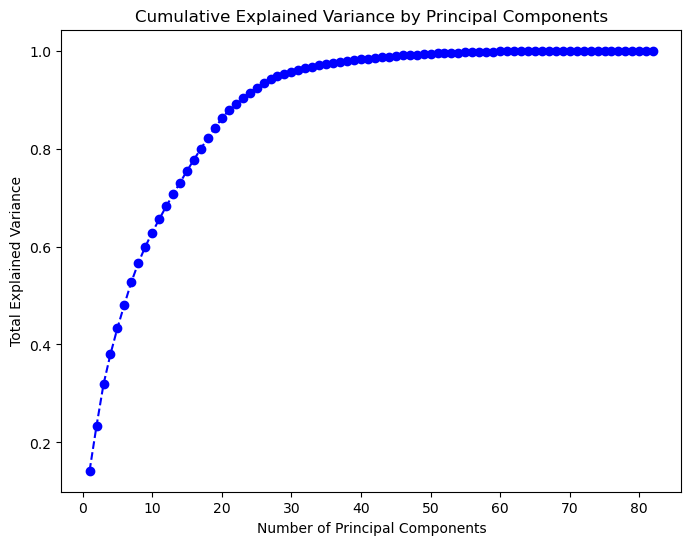

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Total Explained Variance')
plt.show()

In [20]:
# Compute cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Variance explained by first 5 components
variance_5 = cumulative_variance[4]  
print(f"Variance explained by first 5 components: {variance_5:.4f}")

# Variance explained by first 10 components
variance_10 = cumulative_variance[9]  
print(f"Variance explained by first 10 components: {variance_10:.4f}")

# Variance explained by first 20 components
variance_20 = cumulative_variance[19]  
print(f"Variance explained by first 20 components: {variance_20:.4f}")

# Variance explained by first 30 components
variance_30 = cumulative_variance[29]  
print(f"Variance explained by first 30 components: {variance_30:.4f}")

# Variance explained by first 40 components
variance_40 = cumulative_variance[39]  
print(f"Variance explained by first 40 components: {variance_40:.4f}")

Variance explained by first 5 components: 0.4335
Variance explained by first 10 components: 0.6287
Variance explained by first 20 components: 0.8618
Variance explained by first 30 components: 0.9573
Variance explained by first 40 components: 0.9822


<b>We will use the first 40 components and test our XGB model performance<b/>

In [24]:
with open('../data/interim/new_data_url_all_features.pkl', 'rb') as f:
    df = pickle.load(f)
text_features = df.select_dtypes(include=['object'])
df = df.drop(columns=text_features)
df.columns

Index(['status', 'len_url', 'len_url_log', 'len_FQDN', 'len_FQDN_log',
       'len_tld', 'len_tld_log', 'contains_ip', 'url_entropy', 'FQDN_entropy',
       'tld_entropy', 'url_tld_entropy', 'has_js', 'js_entropy', 'num_pat_3',
       'pat_3_entropy', 'pat_3_entropy_log', 'FQDN_len_capital',
       'FQDN_ratio_capital', 'url_len_capital', 'url_len_capital_log',
       'url_ratio_capital', 'url_ratio_capital_log', 'url_char_num_ratio',
       'url_char_num_ratio_log', 'url_spe_char_ratio',
       'url_spe_char_ratio_log', 'FQDN_char_num_ratio',
       'FQDN_char_num_ratio_log', 'FQDN_spe_char_ratio',
       'FQDN_spe_char_ratio_log', 'url_obfuscation_status',
       'FQDN_obfuscation_status', 'obfuscation_entropy_url',
       'obfuscation_entropy_FQDN', 'url_repeated_subs_weight',
       'num_url_reapeated_subs', 'url_num_chunk_weight', 'n_hypens',
       'n_hypens_log', 'n_uscores', 'n_uscores_log', 'n_semicolon',
       'n_semicolon_log', 'n_equal_sign', 'n_equal_sign_log', 'n_plus_si

In [26]:
X = df.drop(columns=['status'])
y = df.status

In [34]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit & transform the whole dataset

# Split data before applying PCA
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Applying PCA *only on training data*
pca = PCA(n_components=40)
X_train_pca = pca.fit_transform(X_train)

# Transform the test set using the already fitted PCA
X_test_pca = pca.transform(X_test)

# Train the model
model = XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.1, eval_metric="logloss")
model.fit(X_train_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [35]:
# Predictions
y_pred = model.predict(X_test_pca)
predictions = [round(value) for value in y_pred]

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.22%


In [36]:
# Calculate recall and F1-score for phishing URLs (0)
recall_phishing = recall_score(y_test, y_pred, pos_label=0)
f1_phishing = f1_score(y_test, y_pred, pos_label=0)

# Calculate recall and F1-score for legitimate URLs (1)
recall_legitimate = recall_score(y_test, y_pred, pos_label=1)
f1_legitimate = f1_score(y_test, y_pred, pos_label=1)

print(f"Phishing URLs (0) - Recall: {recall_phishing:.4f}, F1-score: {f1_phishing:.4f}")
print(f"Legitimate URLs (1) - Recall: {recall_legitimate:.4f}, F1-score: {f1_legitimate:.4f}")

Phishing URLs (0) - Recall: 0.8896, F1-score: 0.8956
Legitimate URLs (1) - Recall: 0.9135, F1-score: 0.9081


```
XGB Classifier (Log vs. Basic features vs. Combined vs. PCA)

Basic features
Phishing URLs (0) - Recall: 0.8944, F1-score: 0.9009 
Legitimate URLs (1) - Recall: 0.9186, F1-score: 0.9127

Log transformed features Phishing URLs (0) - Recall: 0.8945, F1-score: 0.9006 
Legitimate URLs (1) - Recall: 0.9179, F1-score: 0.9124

After applying PCA
Phishing URLs (0) - Recall: 0.8896, F1-score: 0.8956
Legitimate URLs (1) - Recall: 0.9135, F1-score: 0.9081

For XGB Classifier Basic features yields slightly better results.

<span style="color:red;"><b>As the results are marginal in all cases, we will use the BASIC FEATURES to keep the features more interpretable.</b></span>

# 3.7 Machine Learning Algorithms

#### 3.7.1 Applying KNN

In [17]:
with open('../data/interim/new_data_url_all_features.pkl', 'rb') as f:
    df = pickle.load(f)
    
text_features = df.select_dtypes(include=['object'])
df = df.drop(columns=text_features)   

In [18]:
df_knn = df[basic_features]
df_knn.head()

,status,len_url,len_FQDN,len_tld,contains_ip,url_entropy,FQDN_entropy,tld_entropy,url_tld_entropy,has_js,...,FQDN_seg_dot_sep_entropy,tld_fuzzy_score_lev,tld_fuzzy_score_da_nor,tld_similarity_jaro_winkler,dot_probability,sum_spe_prob,similarity_index_legit,similarity_index_phi,english_word_count_url,english_word_count_FQDN
0,0,39,39,3,0,4.045286,4.045286,1.584963,5.630249,0,...,8.032136,100.0,0.0,1.0,0.051282,0.0,0,2,0,0
1,0,36,36,3,0,3.974938,3.974938,1.584963,5.559900,0,...,8.012840,100.0,0.0,1.0,0.055556,0.0,0,1,0,0
2,0,12,12,6,0,2.751629,2.751629,2.251629,5.003258,0,...,2.973557,100.0,0.0,1.0,0.083333,0.0,0,0,0,0
3,0,35,35,3,0,3.943289,3.943289,1.584963,5.528252,0,...,8.137511,100.0,0.0,1.0,0.057143,0.0,0,1,0,0
4,0,20,20,3,0,3.546439,3.546439,1.584963,5.131402,0,...,6.463048,100.0,0.0,1.0,0.100000,0.0,0,0,2,2


In [19]:
X = df_knn.drop(columns=['status'])
y = df_knn.status

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [103]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

In [104]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

Accuracy: 0.8884
Confusion Matrix:
 [[66701  9490]
 [ 8530 76802]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88     76191
           1       0.89      0.90      0.90     85332

    accuracy                           0.89    161523
   macro avg       0.89      0.89      0.89    161523
weighted avg       0.89      0.89      0.89    161523



In [107]:
knn_2 = KNeighborsClassifier(n_neighbors=25)

knn_2.fit(X_train_scaled, y_train)

y_pred = knn_2.predict(X_test_scaled)

In [108]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

Accuracy: 0.8842
Confusion Matrix:
 [[65927 10264]
 [ 8441 76891]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88     76191
           1       0.88      0.90      0.89     85332

    accuracy                           0.88    161523
   macro avg       0.88      0.88      0.88    161523
weighted avg       0.88      0.88      0.88    161523



##### Using elbow method to find best n_neighbors

Value of K:5 
 Accuracy: 0.8846689602095106
Value of K:9 
 Accuracy: 0.8838764991171776
Value of K:13 
 Accuracy: 0.8827419790033609
Value of K:17 
 Accuracy: 0.8815842418139184
Value of K:21 
 Accuracy: 0.8806602192670266
Best k = 5, Accuracy = 0.8847


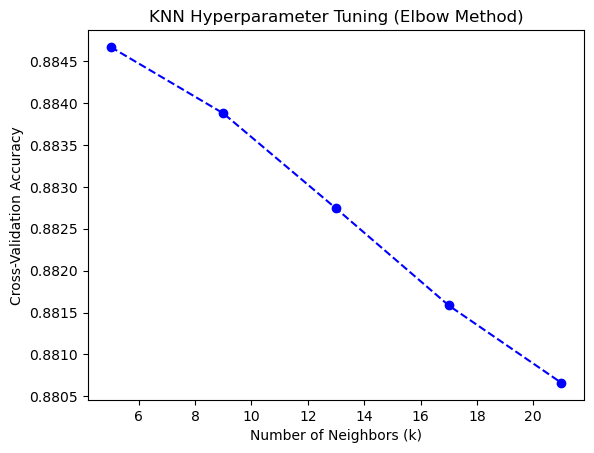

In [27]:
# Range of k values (odd numbers)
k_values = range(5, 25, 4)  
cv_scores = []  # Store cross-validation accuracy

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())  # Store average accuracy
    print(f'Value of K:{k} \n Accuracy: {scores.mean()}')

# Find the best k (highest accuracy)
best_k = k_values[np.argmax(cv_scores)]
print(f"Best k = {best_k}, Accuracy = {max(cv_scores):.4f}")

# Plot k vs accuracy
plt.plot(k_values, cv_scores, marker='o', linestyle='dashed', color='b')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("KNN Hyperparameter Tuning (Elbow Method)")
plt.show()

<b>We could not find a clear elbow point. We will keep n_neighbors=10 to make the model more generalized on unseen data.

<b>KNN uses Euclidean distance by default, but Manhattan might perform better on this dataset.

<b>Using Manhattan distance and n_neighbors=10

In [40]:
knn_man = KNeighborsClassifier(n_neighbors=10, metric='manhattan')

knn_man.fit(X_train_scaled, y_train)

y_pred = knn_man.predict(X_test_scaled)

In [43]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

Accuracy: 0.8911
Confusion Matrix:
 [[68110  8081]
 [ 9513 75819]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89     76191
           1       0.90      0.89      0.90     85332

    accuracy                           0.89    161523
   macro avg       0.89      0.89      0.89    161523
weighted avg       0.89      0.89      0.89    161523



<b>Using Euclidean distance and n_neighbors=10

In [47]:
knn_10 = KNeighborsClassifier(n_neighbors=10, weights='distance')

knn_10.fit(X_train_scaled, y_train)

In [51]:
y_pred = knn_10.predict(X_test_scaled)

In [52]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

Accuracy: 0.8952
Confusion Matrix:
 [[67767  8424]
 [ 8496 76836]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89     76191
           1       0.90      0.90      0.90     85332

    accuracy                           0.90    161523
   macro avg       0.89      0.89      0.89    161523
weighted avg       0.90      0.90      0.90    161523



<b>We do not observe much difference by changing the distance metric. Using weights='distance' yield marginal improvement.

<b>We will keep knn_10 as our final knn model. As it has slight increas in phishing recall.

In [57]:
# with open ('../data/processed/knn.pickle', 'wb') as f:
#     pickle.dump(knn_10, f)

#### 3.7.2 Applying SVM

In [56]:
df = df[basic_features]

<b>Applying SVC to a dataset of this size would be highly time-consuming given our current hardware limitations. To optimize performance, we will downsample the dataset while preserving class balance to ensure efficient training without compromising model integrity.

In [58]:
# Separate phishing (status=0) and legitimate (status=1) samples
df_legit = df[df['status'] == 1]  # Legitimate URLs
df_phish = df[df['status'] == 0]  # Phishing URLs

# Reduce size to 1/10 while keeping balance
df_legit_sample, _ = train_test_split(df_legit, train_size=0.1, random_state=42, stratify=df_legit['status'])
df_phish_sample, _ = train_test_split(df_phish, train_size=0.1, random_state=42, stratify=df_phish['status'])

In [60]:
# Combine the downsampled data
df = pd.concat([df_legit_sample, df_phish_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
print(df['status'].value_counts())

status
1    42665
0    38095
Name: count, dtype: int64


In [62]:
df.head()

,status,len_url,len_FQDN,len_tld,contains_ip,url_entropy,FQDN_entropy,tld_entropy,url_tld_entropy,has_js,...,FQDN_seg_dot_sep_entropy,tld_fuzzy_score_lev,tld_fuzzy_score_da_nor,tld_similarity_jaro_winkler,dot_probability,sum_spe_prob,similarity_index_legit,similarity_index_phi,english_word_count_url,english_word_count_FQDN
0,0,32,13,3,0,4.202820,3.546594,1.584963,5.787782,0,...,4.754888,100.0,0.0,1.0,0.062500,0.000000,0,0,2,0
1,0,73,17,3,0,4.582972,3.572469,1.584963,6.167935,0,...,4.919642,100.0,0.0,1.0,0.013699,0.013699,0,0,4,0
2,1,28,9,3,0,3.851823,2.947703,1.584963,5.436786,0,...,3.506891,100.0,0.0,1.0,0.071429,0.000000,0,0,1,0
3,1,61,15,3,0,4.444750,3.240224,1.584963,6.029713,1,...,4.498940,100.0,0.0,1.0,0.032787,0.032787,0,0,6,0
4,1,53,14,3,0,4.553116,3.093069,1.584963,6.138078,0,...,4.231402,100.0,0.0,1.0,0.037736,0.018868,0,0,3,0


In [64]:
X = df.drop(columns=['status'])
y = df.status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [70]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Initialize SVM model with RBF kernel
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)

# Train the model
svm_model.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [27]:
y_pred = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8573
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      7619
           1       0.85      0.88      0.87      8533

    accuracy                           0.86     16152
   macro avg       0.86      0.86      0.86     16152
weighted avg       0.86      0.86      0.86     16152

[[6315 1304]
 [1001 7532]]


<b>SVC is pretty computation heavy algorithms. Hyperparameter tuning will require a lot of computation power. So hyperparameter tuning on the downsized dataset have to do.

##### 3.7.2.1 Using GrivSearchCV for hyperparameter tuning of SVC on the downsized dataset

In [72]:
param_grid = {
    "C": [0.1, 1, 10],                      # Regularization parameter
    "gamma": ["scale", "auto", 0.01, 0.1],  # Kernel coefficient
    "kernel": ["rbf", "linear", "poly"]     # Different kernel functions
}

grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [73]:
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)
print(f"Final Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")

Final Accuracy: 0.8769


<b>Using the best parameters on the full dataset

In [62]:
with open('../data/interim/new_data_url_all_features.pkl', 'rb') as f:
    df = pickle.load(f)

In [63]:
text_features = df.select_dtypes(include=['object'])
df = df.drop(columns=text_features)

In [64]:
# Features set without the log based transformations
basic_features = ['status', 'len_url','len_FQDN',
       'len_tld','contains_ip', 'url_entropy', 'FQDN_entropy',
       'tld_entropy', 'url_tld_entropy', 'has_js', 'js_entropy', 'num_pat_3',
       'pat_3_entropy','FQDN_ratio_capital', 'url_len_capital',
       'url_ratio_capital', 'url_char_num_ratio','url_spe_char_ratio','FQDN_char_num_ratio',
       'FQDN_spe_char_ratio','url_obfuscation_status','FQDN_obfuscation_status', 'obfuscation_entropy_url',
       'obfuscation_entropy_FQDN', 'url_repeated_subs_weight',
       'num_url_reapeated_subs', 'url_num_chunk_weight', 'n_hypens','n_uscores','n_semicolon','n_equal_sign', 'n_plus_sign',
       'num_segments_FQDN', 'FQDN_seg_dot_sep_entropy',
       'tld_fuzzy_score_lev','tld_fuzzy_score_da_nor','tld_similarity_jaro_winkler','dot_probability',
       'sum_spe_prob', 'similarity_index_legit', 'similarity_index_phi',
       'english_word_count_url', 'english_word_count_FQDN']

In [65]:
df_2 = df[basic_features]

In [67]:
X = df_2.drop(columns=['status'])
y = df_2.status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
svm_model = SVC(kernel="rbf", C=10.0, gamma=0.1, random_state=42)

svm_model.fit(X_train_scaled, y_train)

SVC(C=10.0, gamma=0.1, random_state=42)

In [16]:
y_pred = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8973
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     76191
           1       0.90      0.91      0.90     85332

    accuracy                           0.90    161523
   macro avg       0.90      0.90      0.90    161523
weighted avg       0.90      0.90      0.90    161523

[[67393  8798]
 [ 7783 77549]]


##### Saving the optimized SVC model

In [19]:
# with open('../data/processed/svm_rbf.pkl', 'wb') as f:
#     pickle.dump(svm_model, f)

<b>Increasing class weight to improve recall

In [74]:
svm_model_recall = SVC(kernel="rbf", C=10.0, gamma=0.1, class_weight={0: 1, 1: 1.2}, random_state=42)

svm_model_recall.fit(X_train_scaled, y_train)

SVC(C=10.0, class_weight={0: 1, 1: 1.2}, gamma=0.1, random_state=42)

In [75]:
y_pred = svm_model_recall.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8964
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     76191
           1       0.89      0.92      0.90     85332

    accuracy                           0.90    161523
   macro avg       0.90      0.89      0.90    161523
weighted avg       0.90      0.90      0.90    161523

[[66276  9915]
 [ 6819 78513]]


<b>The shift in class weights boosts the recall for phishing URLs, but an overly high recall can lead to an increase in false positives. This could overwhelm the model with incorrect classifications, making it less efficient and practical.

In [79]:
# with open('../data/processed/svm_model_opt_recall.pkl', 'wb') as f:
#     pickle.dump(svm_model_recall, f)

<b>Phishing URLs (Class 0) are slightly more penalized than legitimate ones.
Since we set class_weight={0:1, 1:1.2}, the model tries to increase recall for phishing URLs by misclassifying fewer phishing links as legitimate.
However, this also increases false positives (legitimate URLs classified as phishing), which may lead to unnecessary security warnings.

#### 3.7.3 Improving XGBoostClassifer

##### 3.7.3.1 Hyperparameter tunning using RandomSearchCV

In [130]:
with open('../data/interim/new_data_url_all_features.pkl', 'rb') as f:
    df = pickle.load(f)
    
text_features = df.select_dtypes(include=['object'])
df = df.drop(columns=text_features) 

In [131]:
df = df[basic_features]

In [132]:
X = df.drop(columns=['status'])
y = df.status

<b>Using Recall for optimization metric

In [60]:
# Standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit & transform the whole dataset

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Definning parameter grid for RandomizedSearchCV
param_dist = {
    "n_estimators": [50, 100, 200, 300],      # Number of boosting rounds
    "max_depth": [3, 5, 7, 10],               # Maximum depth of trees
    "learning_rate": [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    "subsample": [0.6, 0.8, 1.0],             # Fraction of samples used per boosting round
    "colsample_bytree": [0.6, 0.8, 1.0],      # Fraction of features used per tree
    "gamma": [0, 0.1, 0.2, 0.3],              # Min loss reduction to split a node
    "reg_alpha": [0, 0.01, 0.1, 1],           # L1 regularization
    "reg_lambda": [0.1, 1, 10]                # L2 regularization
}

# Initializing model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

# Using recall as the scoring metric
recall_scorer = make_scorer(recall_score, average="binary")  

# RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,              # Number of random samples to try
    scoring=recall_scorer,  # Optimize recall
    cv=5,                   # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  
)

# Fitting RandomizedSearchCV on training data
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
4 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1512, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^

Best Parameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [64]:
# Trainning XGBoost with best parameters
best_xgb = XGBClassifier(**random_search.best_params_, eval_metric="logloss")
best_xgb.fit(X_train, y_train)

# Predictions
y_pred = best_xgb.predict(X_test)

# Computing Recall
recall = recall_score(y_test, y_pred, average="binary")  # Use "macro" for multi-class
print("Optimized XGBoost Recall: %.2f%%" % (recall * 100.0))

Optimized XGBoost Recall: 92.44%


In [66]:
# Predictions on training and test sets
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

# Calculate recall
train_recall = recall_score(y_train, y_train_pred, average='binary')  # For binary classification
test_recall = recall_score(y_test, y_test_pred, average='binary')

print(f"Training Recall: {train_recall:.4f}")
print(f"Validation Recall: {test_recall:.4f}")

# Check recall gap
recall_gap = train_recall - test_recall
print(f"Recall Gap: {recall_gap:.4f}")

Training Recall: 0.9260
Validation Recall: 0.9244
Recall Gap: 0.0016


<b>Using n_estimator = 10<b/>

<b>We will keep the max_depth=7 to prevent any possible overfitting

In [137]:
# To reduce the risk of overfitting and underfitting we will manually tweak the parameters and see resutls
xgb_2 = XGBClassifier(subsample=0.6, 
                         reg_lambda=1, 
                         reg_alpha=0.01, 
                         n_estimators=10,
                         max_depth=7, 
                         learning_rate=0.01, 
                         gamma=0.1, 
                         colsample_bytree=0.8,
                         eval_metric="logloss")

xgb_2.fit(X_train, y_train)

# Predictions
y_pred = xgb_2.predict(X_test)

recall = recall_score(y_test, y_pred, average="binary") 
print("Optimized XGBoost Recall: %.2f%%" % (recall * 100.0))

Optimized XGBoost Recall: 97.60%


In [128]:
# Predictions on training and test sets
y_train_pred = xgb_2.predict(X_train)
y_test_pred = xgb_2.predict(X_test)

# Calculate recall
train_recall = recall_score(y_train, y_train_pred, average='binary')  # For binary classification
test_recall = recall_score(y_test, y_test_pred, average='binary')

print(f"Training Recall: {train_recall:.4f}")
print(f"Validation Recall: {test_recall:.4f}")

# Check recall gap
recall_gap = train_recall - test_recall
print(f"Recall Gap: {recall_gap:.4f}")

Training Recall: 0.9757
Validation Recall: 0.9760
Recall Gap: -0.0003


In [130]:
# Calculate Precision, F1 Score, and Accuracy
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print("Precision: %.2f%%" % (precision * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Precision: 71.74%
F1 Score: 82.69%
Accuracy: 78.41%


<b>Using n_estimator = 100<b/>

In [90]:
# To reduce the risk of overfitting and underfitting we will manually tweak the parameters and see resutls
# We will keep the max_depth=7 to prevent any possible overfitting
xgb_2 = XGBClassifier(subsample=0.6, 
                         reg_lambda=1, 
                         reg_alpha=0.01, 
                         n_estimators=100,
                         max_depth=7, 
                         learning_rate=0.01, 
                         gamma=0.1, 
                         colsample_bytree=0.8,
                         eval_metric="logloss")

xgb_2.fit(X_train, y_train)

# Predictions
y_pred = xgb_2.predict(X_test)

# Compute Recall
recall = recall_score(y_test, y_pred, average="binary")  # Use "macro" for multi-class
print("Optimized XGBoost Recall: %.2f%%" % (recall * 100.0))

Optimized XGBoost Recall: 90.89%


In [92]:
# Predictions on training and test sets
y_train_pred = xgb_2.predict(X_train)
y_test_pred = xgb_2.predict(X_test)

# Calculate recall
train_recall = recall_score(y_train, y_train_pred, average='binary')  # For binary classification
test_recall = recall_score(y_test, y_test_pred, average='binary')

print(f"Training Recall: {train_recall:.4f}")
print(f"Validation Recall: {test_recall:.4f}")

# Check recall gap
recall_gap = train_recall - test_recall
print(f"Recall Gap: {recall_gap:.4f}")

Training Recall: 0.9079
Validation Recall: 0.9089
Recall Gap: -0.0011


In [94]:
# Calculate Precision, F1 Score, and Accuracy
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print("Precision: %.2f%%" % (precision * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Precision: 81.71%
F1 Score: 86.06%
Accuracy: 84.43%


<b>Impact of n_estimators (Number of Trees)

<b>Lower n_estimators (10 trees)

Achieves higher recall (97.60%), meaning it correctly identifies more phishing URLs.
But at the cost of lower precision (71.74%), meaning more false positives (legitimate URLs misclassified as phishing).
Lower accuracy (78.41%) suggests it's underfitting or too simplistic.

<b>Higher n_estimators (100 trees)

Recall drops to 90.89%, meaning more phishing URLs are missed.
However, precision improves significantly (81.71%), reducing false alarms.
Higher F1-score (86.06%) and accuracy (84.43%), meaning the model generalizes better.

<b>Overfitting vs. Underfitting</b>

n=10 appears underfitted.
The model over-prioritizes recall, leading to many false positives (phishing misclassified too often).
The low number of trees makes predictions unstable.

n=100 is more balanced.
The model becomes more discriminative, improving overall accuracy and precision.
However, recall drops, meaning more phishing URLs are missed (false negatives increase).
This suggests a better trade-off between recall and precision.

<b>Improvements steps

Since more trees (higher n_estimators) slow learning, increasing learning_rate slightly (e.g., 0.02–0.05) might compensate for lost recall.


Since phishing recall is our priority, trying scale_pos_weight (Tuning Class Weights) to penalize false negatives more heavily might yeild better resutls.

scale_pos_weight is a hyperparameter in XGBoost that adjusts how much misclassified minority class samples (False Negatives) are penalized during training.

How It Works:
The default value is 1.0, meaning both classes are treated equally.
When scale_pos_weight > 1.0, the model gives more importance to the minority class (phishing in our case, class 0).
This reduces false negatives (phishing URLs misclassified as legitimate) by making the model more cautious about missing phishing URLs.

<b>Repeating the hyperparameter tuning step

In [115]:
# Standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit & transform the whole dataset

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [117]:
# Definning parameter grid for RandomizedSearchCV
param_dist = {
    "n_estimators": [50, 100, 150],            # Number of boosting rounds
    "max_depth": [7],                          # Maximum depth of trees
    "learning_rate": [0.02, 0.03, 0.05, 0.1],  # Step size shrinkage
    "subsample": [0.6, 0.8, 1.0],              # Fraction of samples used per boosting round
    "colsample_bytree": [0.6, 0.8, 1.0],       # Fraction of features used per tree
    "gamma": [0.1],                            # Min loss reduction to split a node
    "reg_alpha": [0.01],                       # L1 regularization
    "reg_lambda": [1]                          # L2 regularization
}

# Initializing model
xgb_model_tuned = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

# Using recall as the scoring metric
recall_scorer = make_scorer(recall_score, average="binary")  

# RandomizedSearchCV with 3-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model_tuned,
    param_distributions=param_dist,
    n_iter=20,              # Number of random samples to try
    scoring=recall_scorer,  # Optimize recall
    cv=3,                   # 3-fold cross-validation
    verbose=5,
    random_state=42,
    n_jobs=-1  
)

# Fitting RandomizedSearchCV on training data
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
3 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1512, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^

Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}


In [160]:
# Trainning XGBoost with best parameters
xgb_tuned_3 = XGBClassifier(**random_search.best_params_, scale_pos_weight=1.5, eval_metric="logloss")
xgb_tuned_3.fit(X_train, y_train)

y_pred = xgb_tuned_3.predict(X_test)

In [161]:
# Predictions on training and test sets
y_train_pred = xgb_tuned_3.predict(X_train)
y_test_pred = xgb_tuned_3.predict(X_test)

# Calculate recall
train_recall = recall_score(y_train, y_train_pred, average='binary')  # For binary classification
test_recall = recall_score(y_test, y_test_pred, average='binary')

print(f"Training Recall: {train_recall:.4f}")
print(f"Validation Recall: {test_recall:.4f}")

# Check recall gap
recall_gap = train_recall - test_recall
print(f"Recall Gap: {recall_gap:.4f}")

Training Recall: 0.9424
Validation Recall: 0.9407
Recall Gap: 0.0017


In [162]:
# Calculate Precision, F1 Score, and Accuracy
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print("Precision: %.2f%%" % (precision * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Precision: 85.62%
F1 Score: 89.64%
Accuracy: 88.51%


In [175]:
# Confusion matrix for the training set
train_cm = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix (Training Set):\n", train_cm)

# Confusion matrix for the test set
print('\n')
test_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):\n", test_cm)

Confusion Matrix (Training Set):
 [[251715  53090]
 [ 19669 321614]]


Confusion Matrix (Test Set):
 [[62658 13492]
 [ 5063 80310]]


```

n_estimator = 10      n_estimator = 100         n_estimator = 150 (After final tuning)
Precision: 71.74%     Precision: 81.71%         Precision: 85.62%
F1 Score: 82.69%      F1 Score: 86.06%          F1 Score: 89.64%
Accuracy: 78.41%      Accuracy: 84.43%          Accuracy: 88.51%

<b>Moving from 10 to 100 estimators significantly increased precision (71.74% → 81.71%) and accuracy (78.41% → 84.43%).
More trees help the model capture patterns better, reducing bias.

<b>The final model (with n_estimators=150 and learning_rate=0.1 with scale_pos_weight=1.5 ( Misclassified minority class samples (False Negatives) are penalized more during training)) boosted precision to 85.62% and accuracy to 88.51%.

<b>A learning rate of 0.01 took longer to learn patterns, but increasing it to 0.1 helped optimize performance faster.

<b>Keeping max_depth=7 helped prevent overfitting, ensuring that the additional trees don't make the model too complex.
Too many trees with a very high learning rate can cause overfitting, but 150 estimators + 0.1 learning rate hopefully will struck a good balance when tested.

#### 3.7.4 Using TF-IDF on 'url'

<b>We will apply TF-IDF to 'url' column, to see if we can push the scores even higher.

<b>Term Frequency-Inverse Document Frequency (TF-IDF) is a statistical measure that evaluates the importance of words (or subwords) in a document relative to a collection (or corpus).

In [5]:
with open('../data/interim/new_data_url_all_features.pkl', 'rb') as f:
    df = pickle.load(f)

In [7]:
text_features = df.select_dtypes(include=['object'])

In [9]:
text_features = text_features.drop(columns=['url'])

In [11]:
df = df.drop(columns=text_features) 

In [13]:
df.head()

,url,status,len_url,len_url_log,len_FQDN,len_FQDN_log,len_tld,len_tld_log,contains_ip,url_entropy,...,exclamation_probability_log,plus_probability_log,sum_spe_prob_log,sum_spe_prob,similarity_index_legit,similarity_index_phi,similarity_index_legit_log,similarity_index_phi_log,english_word_count_url,english_word_count_FQDN
0,0000111servicehelpdesk.godaddysites.com,0,39,3.688879,39,3.688879,3,1.386294,0,4.045286,...,0.0,0.0,0.0,0.0,0,2,0.0,1.098612,0,0
1,000011accesswebform.godaddysites.com,0,36,3.610918,36,3.610918,3,1.386294,0,3.974938,...,0.0,0.0,0.0,0.0,0,1,0.0,0.693147,0,0
2,00003.online,0,12,2.564949,12,2.564949,6,1.945910,0,2.751629,...,0.0,0.0,0.0,0.0,0,0,0.0,0.000000,0,0
3,0009servicedeskowa.godaddysites.com,0,35,3.583519,35,3.583519,3,1.386294,0,3.943289,...,0.0,0.0,0.0,0.0,0,1,0.0,0.693147,0,0
4,000n38p.wcomhost.com,0,20,3.044522,20,3.044522,3,1.386294,0,3.546439,...,0.0,0.0,0.0,0.0,0,0,0.0,0.000000,2,2


In [15]:
# Features set without the log based transformations
basic_features_tf = ['status', 'url', 'len_url','len_FQDN',
       'len_tld','contains_ip', 'url_entropy', 'FQDN_entropy',
       'tld_entropy', 'url_tld_entropy', 'has_js', 'js_entropy', 'num_pat_3',
       'pat_3_entropy','FQDN_ratio_capital', 'url_len_capital',
       'url_ratio_capital', 'url_char_num_ratio','url_spe_char_ratio','FQDN_char_num_ratio',
       'FQDN_spe_char_ratio','url_obfuscation_status','FQDN_obfuscation_status', 'obfuscation_entropy_url',
       'obfuscation_entropy_FQDN', 'url_repeated_subs_weight',
       'num_url_reapeated_subs', 'url_num_chunk_weight', 'n_hypens','n_uscores','n_semicolon','n_equal_sign', 'n_plus_sign',
       'num_segments_FQDN', 'FQDN_seg_dot_sep_entropy',
       'tld_fuzzy_score_lev','tld_fuzzy_score_da_nor','tld_similarity_jaro_winkler','dot_probability',
       'sum_spe_prob', 'similarity_index_legit', 'similarity_index_phi',
       'english_word_count_url', 'english_word_count_FQDN']

In [17]:
df = df[basic_features_tf]

In [19]:
X = df.drop(columns=['status'])  
y = df['status']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [37]:
# Creating the TF-IDF + SVD pipeline
tfidf_svd_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='char', use_idf=False, norm='l1', ngram_range=(1, 3))),
    ('svd', TruncatedSVD(n_components=40))
])

Given that TF-IDF generates high-dimensional sparse representations, we applied Truncated Singular Value Decomposition (TruncatedSVD) for dimensionality reduction. This technique compresses the TF-IDF feature space while preserving essential information.

In [39]:
X_train_tfidf_svd = tfidf_svd_pipeline.fit_transform(X_train['url'])

# Transforming test data using the fitted pipeline (NO fitting on test data)
X_test_tfidf_svd = tfidf_svd_pipeline.transform(X_test['url'])

In [40]:
# Converting to DataFrame
X_train_tfidf_svd_df = pd.DataFrame(X_train_tfidf_svd, index=X_train.index)
X_test_tfidf_svd_df = pd.DataFrame(X_test_tfidf_svd, index=X_test.index)

# Dropping original 'FQDN' column and concatenating new transformed features
X_train_final = pd.concat([X_train.drop(columns=['url']).reset_index(drop=True), X_train_tfidf_svd_df.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test.drop(columns=['url']).reset_index(drop=True), X_test_tfidf_svd_df.reset_index(drop=True)], axis=1)

# Checking variance explained by SVD
explained_variance = tfidf_svd_pipeline.named_steps['svd'].explained_variance_ratio_.sum()
print(f"Explained Variance Ratio: {explained_variance:.4f}")

print(X_train_final.head())

Explained Variance Ratio: 0.4479
   len_url  len_FQDN  len_tld  contains_ip  url_entropy  FQDN_entropy  \
0       31        11        3            0     4.567100      3.095795   
1       80        26        3            0     4.798822      3.946223   
2       31        11        3            0     4.389365      3.095795   
3       33        14        2            1     3.896688      2.495603   
4       61        21        2            0     4.333591      3.653757   

   tld_entropy  url_tld_entropy  has_js  js_entropy  ...        30        31  \
0     1.584963         6.152062       1    3.584963  ... -0.002465  0.002807   
1     1.584963         6.383785       1    2.584963  ...  0.002891  0.003951   
2     1.584963         5.974327       1    3.584963  ... -0.000872  0.004493   
3    -0.000000         3.896688       0    0.000000  ... -0.005341  0.005132   
4     1.000000         5.333591       0    0.000000  ... -0.000092 -0.004115   

         32        33        34        35      

In [45]:
xgb_tf = XGBClassifier(subsample=0.8, 
                         reg_lambda=1, 
                         reg_alpha=0.01, 
                         n_estimators=150,
                         max_depth=7, 
                         learning_rate=0.1, 
                         gamma=0.1, 
                         colsample_bytree=1.0,
                         scale_pos_weight=1.5,
                         eval_metric="logloss")

xgb_tf.fit(X_train_final, y_train)

# Predictions
y_pred = xgb_tf.predict(X_test_final)

In [68]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Generate classification report
report = classification_report(y_test, y_pred)

# Print the report
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix \n", conf_matrix)

Accuracy: 90.87%
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     76191
           1       0.88      0.95      0.92     85332

    accuracy                           0.91    161523
   macro avg       0.91      0.91      0.91    161523
weighted avg       0.91      0.91      0.91    161523

Confusion Matrix 
 [[65579 10612]
 [ 4137 81195]]


In [50]:
# Save the model to a file
with open("../data/processed/xgb_model_tf.pkl", "wb") as f:
    pickle.dump(xgb_tf, f)

print("Model saved successfully!")

Model saved successfully!


# 3.8 Comparing the Final Models

In [4]:
# Model names
models = ["KNN", "SVC", "XGBoost"]

# Accuracy values
accuracy = [0.8952, 0.8964, 0.9087]

# Precision (Legit, Phishing)
precision_legit = [0.89, 0.91, 0.94]
precision_phishing = [0.90, 0.89, 0.88]

# Recall (Legit, Phishing)
recall_legit = [0.89, 0.87, 0.86]
recall_phishing = [0.90, 0.92, 0.95]

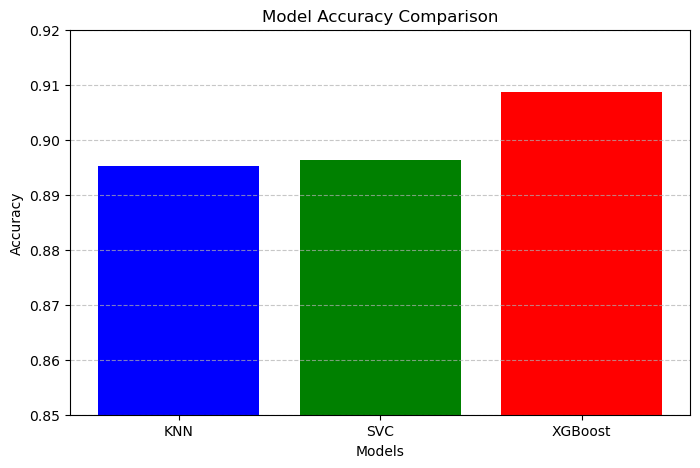

In [6]:
# Bar Chart for Accuracy
plt.figure(figsize=(8, 5))
plt.bar(models, accuracy, color=['blue', 'green', 'red'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0.85, 0.92)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()

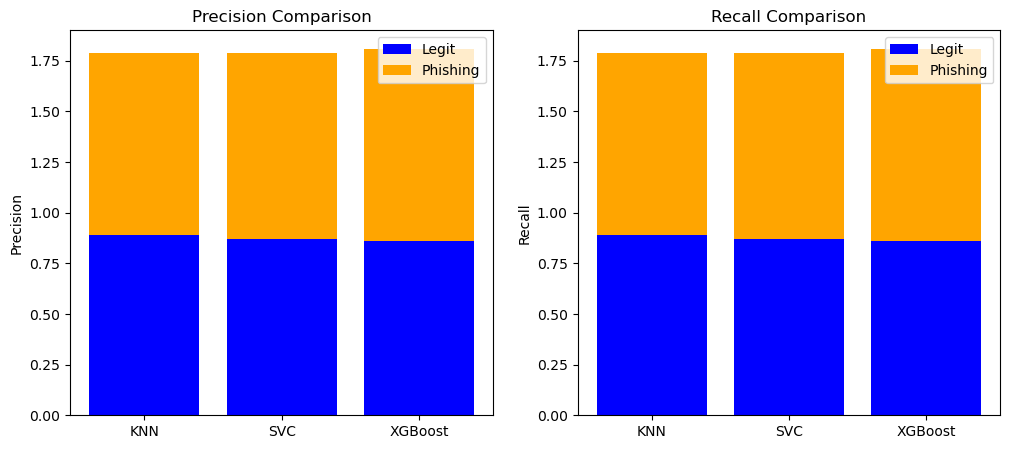

In [13]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Precision Plot
ax[0].bar(models, recall_legit, color='blue', label="Legit")
ax[0].bar(models, recall_phishing, color='orange', bottom=recall_legit, label="Phishing")
ax[0].set_title("Precision Comparison")
ax[0].set_ylabel("Precision")
ax[0].legend()

# Recall Plot
ax[1].bar(models, recall_legit, color='blue', label="Legit")
ax[1].bar(models, recall_phishing, color='orange', bottom=recall_legit, label="Phishing")
ax[1].set_title("Recall Comparison")
ax[1].set_ylabel("Recall")
ax[1].legend()

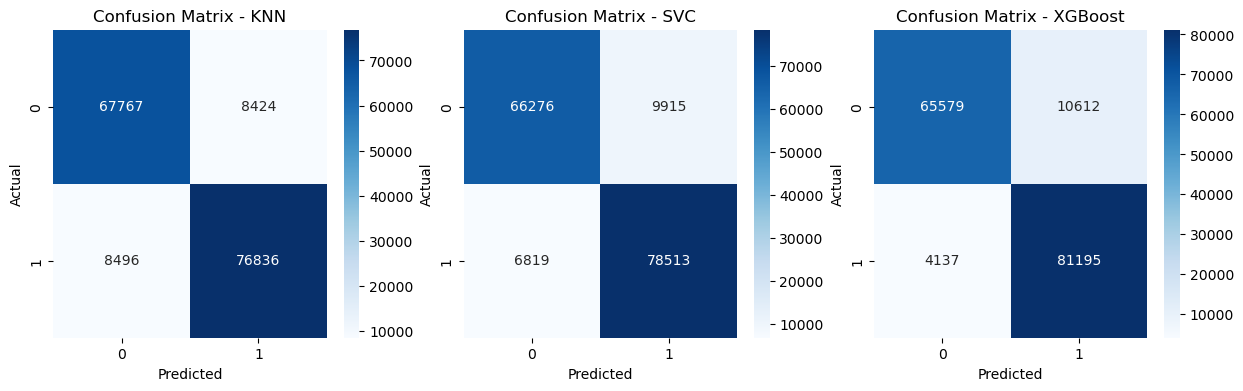

In [94]:
# Confusion Matrices
conf_matrices = {
    "KNN": np.array([[67767, 8424], [8496, 76836]]),
    "SVC": np.array([[66276, 9915], [6819, 78513]]),
    "XGBoost": np.array([[65579, 10612], [4137, 81195]])
}

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (model, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"Confusion Matrix - {model}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.show()

### Key Observations from the Model Performance

#### XGBoost is the Best Performing Model.

<b>It has the highest overall accuracy (90.87%) among the three models.
<b>Precision (0.94 for legit, 0.88 for phishing) and Recall (0.86 for legit, 0.95 for phishing) indicate a strong ability to correctly classify both classes.
<b>The false negative rate (missed phishing URLs) is significantly lower than KNN and SVC.
This suggests XGBoost is the most balanced model in terms of detecting phishing while minimizing false alarms.

#### KNN Shows Decent Performance but Struggles with Phishing Detection.<br> 

<b>Accuracy: 89.52% (lower than SVC and XGBoost).<br>
<b>It has comparable precision (0.89 legit, 0.90 phishing) and recall, but more false negatives (phishing misclassified as legit) compared to the other models.

#### SVC is Competitive but Slightly Underperforms XGBoost.

<b>Accuracy: 89.64% (better than KNN but slightly lower than XGBoost).<br>
Better precision for phishing URLs (0.89) than KNN, but still not as high as XGBoost.<br>
Recall for phishing (0.92) is good but comes at the cost of a higher false positive rate (0.87 legit recall).<br>
It is still an effective model, especially with class weighting to handle imbalanced data.

### Final Conclusion

<b>XGBoost is the best choice for phishing URL detection in this case due to its higher recall and precision, fewer false negatives, and overall better performance.

<b>SVC can be a strong alternative but has a slightly higher false positive rate.<br>
KNN is the weakest performer. Since KNN relies heavily on distance-based similarity, it may struggle with complex decision boundaries required for phishing detection. Considering k-Nearest Centroid Classifier or DBSCAN clustering instead of KNN might yield better phishing URL detection.

# 3.9 Scope for future improvements

<b>URLs are primarily text-based, and there are many powerful techniques to extract more meaningful insights. For example, techniques like Word2Vec could be applied to compare URL components in more sophisticated ways. Currently, similarities are calculated based on exact matches due to limitations in computational power, but partial matching could yield better performance.

<b>In future work, instead of using a static similarity index between top-level domains extracted from Wikipedia, we could dynamically compute the similarity between URLs extracted directly from the web and the URLs in our dataset. This would make the approach more adaptive and up-to-date. 

<b>Additionally, tools from NLTK, such as Latent Semantic Analysis (LSA), or even more advanced models like BERT, could be applied to improve the comparison and scoring process.